In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# Convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for specific humidity
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for specific humidity
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for specific humidity
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    #print("Agg:")
    agg.columns = names
    #print(type(agg))
    #print(agg)

    #print("Test columns:")
    #print(agg.iloc[:, -37]) # Column containing response actual values (specific humidity) at time t-3
    #print(agg.iloc[:, -25]) # Column containing response actual values (specific humidity) at time t-2
    #print(agg.iloc[:, -13]) # Column containing response actual values (specific humidity) at time t-1
    #print(agg.iloc[:, -1]) # Column containing response actual values (specific humidity) at time t
    
    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 27 time steps (the first 23 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 26-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 23 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (specific_humidity) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    #print("Scaled values rows:")
    #print(len(scaled_values))

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    # Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    
    
    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 2:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 10
if n_seq > 3:
    n_lag = 25 - n_seq
else:
    n_lag = 22
n_time_steps = 27
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([5, 9, 21, 22, 41, 42, 45, 46, 52, 66, 68, 72, 79, 81, 82, 83, 90, 92, 95])
test_array.append([4, 10, 47, 53, 94])
    
train_array.append([4, 9, 10, 21, 41, 45, 46, 47, 52, 53, 66, 68, 81, 82, 83, 90, 92, 94, 95])
test_array.append([5, 22, 42, 72, 79])
    
train_array.append([4, 5, 10, 21, 22, 41, 42, 46, 47, 52, 53, 72, 79, 82, 83, 90, 92, 94, 95])
test_array.append([9, 45, 66, 68, 81])
    
train_array.append([4, 5, 9, 10, 21, 22, 42, 45, 47, 52, 53, 66, 68, 72, 79, 81, 82, 92, 94, 95])
test_array.append([41, 46, 83, 90])
    
train_array.append([4, 5, 9, 10, 22, 41, 42, 45, 46, 47, 53, 66, 68, 72, 79, 81, 83, 90, 94])
test_array.append([21, 52, 82, 92, 95])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Yearly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')

# Swap columns 'temperatures' and 'specific_humidity' directly
df['A'] = df['temperatures']
df['temperatures'] = df['specific_humidity']
df['specific_humidity'] = df['A']
df = df.drop(columns=['A'])
# Rename columns
df = df.rename(columns={'temperatures': 'specific_humidity', 'specific_humidity': 'temperatures'})

print(df)
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when solar activity is removed as a predictor
df_trimmed = df_trimmed.drop(['solar_activity'], axis=1)

n_vars = df_trimmed.shape[1]-1

X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['specific_humidity'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['specific_humidity'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)

print(df_trimmed)
print(new_df)
print(X[0])

#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of the train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of the validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
    #print("Train_X Fold "+str(i)+":")
    #print(len(train_X[i]))
    #print(len(train_X[i][0]))
    #print(len(train_X[i][0][0])) 
    #print("Train_y Fold "+str(i)+":")
    #print(len(train_y[i]))
    #print(len(train_y[i][0]))
    #print(train_y[i][0][0])
    #print("Validation_X Fold "+str(i)+":")
    #print(len(val_X[i]))
    #print(len(val_X[i][0]))
    #print(len(val_X[i][0][0]))
    #print("Validation_y Fold "+str(i)+":")
    #print(len(val_y[i]))
    #print(len(val_y[i][0]))
    #print(val_y[i][0][0])
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    if i==3:
        train_size = 20
        val_size = 4
    else:
        train_size = 19
        val_size = 5
        
    for k in range(train_size):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
     

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(train_size):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['specific_humidity']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(val_size):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(val_size):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['specific_humidity']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(train_size):
        train2.append(train1[k][0])
        
    for k in range(2):
        test2.append(test1[k][0])

    for k in range(val_size-2):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(train_size, dim_size)
    test1 = np.array(test[i]).reshape(2, dim_size)
    validation1 = np.array(validation[i]).reshape(val_size-2, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]

print("Finished")

Model Parameters:
n_lag (number of input time steps): 15
n_seq (number of output/future prediction time steps): 10
C:\Users\User
C:\Users\User\Modeling\
     file_id        date  specific_humidity          slp  vapor_pressure  \
0       6678  1998-12-31          12.816968  1016.202508       20.726068   
1       6678  1999-12-31          12.330412  1017.480181       19.960131   
2       6678  2000-12-31          12.136613  1018.259826       19.655271   
3       6678  2001-12-31          11.897962  1018.414173       19.285320   
4       6678  2002-12-31          12.751085  1017.916636       20.638060   
..       ...         ...                ...          ...             ...   
643     8000  2020-12-31           5.146134  1016.944161        8.168785   
644     8000  2021-12-31           5.239193  1016.159983        8.312383   
645     8000  2022-12-31           5.362553  1017.898453        8.512894   
646     8000  2023-12-31           5.430746  1016.166709        8.612808   
647     800

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

10
15
(19, 175)
(2, 175)


[I 2025-06-06 22:42:33,145] A new study created in memory with name: no-name-8ec6b5a4-0d4a-4649-9393-1674b3bdaad7
[I 2025-06-06 22:43:36,127] Trial 0 finished with value: 0.11404753625392913 and parameters: {'lr': 0.006075190037390305, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.14017516619718473}. Best is trial 0 with value: 0.11404753625392913.


Cross Validation Accuracies:
[0.10026250034570694, 0.13449442386627197, 0.09828203916549683, 0.14783822000026703, 0.08936049789190292]
Mean Cross Validation Accuracy:
0.11404753625392913
Standard Deviation of Cross Validation Accuracy:
0.022838185118793042


[I 2025-06-06 22:45:01,888] Trial 1 finished with value: 0.09777070134878159 and parameters: {'lr': 0.004999058031414261, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.25793765717915185}. Best is trial 1 with value: 0.09777070134878159.


Cross Validation Accuracies:
[0.10031777620315552, 0.10355246812105179, 0.10006406903266907, 0.10712197422981262, 0.07779721915721893]
Mean Cross Validation Accuracy:
0.09777070134878159
Standard Deviation of Cross Validation Accuracy:
0.010310792869691332


[I 2025-06-06 22:46:53,756] Trial 2 finished with value: 14.368078804016113 and parameters: {'lr': 0.1622064025773568, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.39283608902181555}. Best is trial 1 with value: 0.09777070134878159.


Cross Validation Accuracies:
[12.815420150756836, 17.532276153564453, 18.13397789001465, 8.476794242858887, 14.881925582885742]
Mean Cross Validation Accuracy:
14.368078804016113
Standard Deviation of Cross Validation Accuracy:
3.509306540587141


[I 2025-06-06 22:47:46,267] Trial 3 finished with value: 0.3073258548974991 and parameters: {'lr': 0.00696289167239172, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4592611570022812}. Best is trial 1 with value: 0.09777070134878159.


Cross Validation Accuracies:
[0.26810842752456665, 0.2473234087228775, 0.247314453125, 0.4651675820350647, 0.3087154030799866]
Mean Cross Validation Accuracy:
0.3073258548974991
Standard Deviation of Cross Validation Accuracy:
0.08204341554239568


[I 2025-06-06 22:48:50,031] Trial 4 finished with value: 0.5971159890294075 and parameters: {'lr': 0.046301216518759666, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.11539418880025042}. Best is trial 1 with value: 0.09777070134878159.


Cross Validation Accuracies:
[2.61199951171875, 0.09139786660671234, 0.09599114209413528, 0.1100141778588295, 0.07617724686861038]
Mean Cross Validation Accuracy:
0.5971159890294075
Standard Deviation of Cross Validation Accuracy:
1.0074996664115956


[I 2025-06-06 22:50:14,475] Trial 5 finished with value: 0.17371852695941925 and parameters: {'lr': 0.10108318260412, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.4421426332541841}. Best is trial 1 with value: 0.09777070134878159.


Cross Validation Accuracies:
[0.17545834183692932, 0.18602432310581207, 0.1530696600675583, 0.18085786700248718, 0.1731824427843094]
Mean Cross Validation Accuracy:
0.17371852695941925
Standard Deviation of Cross Validation Accuracy:
0.01124360121149563


[I 2025-06-06 22:51:41,055] Trial 6 finished with value: 0.14128608852624894 and parameters: {'lr': 0.23626869633427583, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.22022343021788357}. Best is trial 1 with value: 0.09777070134878159.


Cross Validation Accuracies:
[0.1512555629014969, 0.13085584342479706, 0.14392967522144318, 0.1593344807624817, 0.12105488032102585]
Mean Cross Validation Accuracy:
0.14128608852624894
Standard Deviation of Cross Validation Accuracy:
0.01378561011030043


[I 2025-06-06 22:52:39,537] Trial 7 finished with value: 0.21985290050506592 and parameters: {'lr': 0.009014254546996907, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.17479669636825357}. Best is trial 1 with value: 0.09777070134878159.


Cross Validation Accuracies:
[0.17293789982795715, 0.14786916971206665, 0.21447552740573883, 0.3918266296386719, 0.17215527594089508]
Mean Cross Validation Accuracy:
0.21985290050506592
Standard Deviation of Cross Validation Accuracy:
0.0886133374047552


[I 2025-06-06 22:53:59,967] Trial 8 finished with value: 0.4284460186958313 and parameters: {'lr': 0.02662720385377092, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.46588966581028224}. Best is trial 1 with value: 0.09777070134878159.


Cross Validation Accuracies:
[0.3845147490501404, 0.4238368570804596, 0.4593360126018524, 0.33732783794403076, 0.5372146368026733]
Mean Cross Validation Accuracy:
0.4284460186958313
Standard Deviation of Cross Validation Accuracy:
0.06788008204971895


[I 2025-06-06 22:55:55,009] Trial 9 finished with value: 0.8850666522979737 and parameters: {'lr': 0.013667843218737442, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.4314533264585968}. Best is trial 1 with value: 0.09777070134878159.


Cross Validation Accuracies:
[0.9257126450538635, 0.9535069465637207, 0.8467930555343628, 0.9526400566101074, 0.7466805577278137]
Mean Cross Validation Accuracy:
0.8850666522979737
Standard Deviation of Cross Validation Accuracy:
0.07939510684699622


[I 2025-06-06 22:57:00,491] Trial 10 finished with value: 0.09553717225790023 and parameters: {'lr': 0.001335938584735494, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.31960078979418505}. Best is trial 10 with value: 0.09553717225790023.


Cross Validation Accuracies:
[0.09844522178173065, 0.0963553860783577, 0.09173065423965454, 0.11330592632293701, 0.07784867286682129]
Mean Cross Validation Accuracy:
0.09553717225790023
Standard Deviation of Cross Validation Accuracy:
0.011421273458281507


[I 2025-06-06 22:57:58,850] Trial 11 finished with value: 0.09860494434833526 and parameters: {'lr': 0.0010825019542919031, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.30244157857909537}. Best is trial 10 with value: 0.09553717225790023.


Cross Validation Accuracies:
[0.09896783530712128, 0.11732326447963715, 0.09042390435934067, 0.10781346261501312, 0.07849625498056412]
Mean Cross Validation Accuracy:
0.09860494434833526
Standard Deviation of Cross Validation Accuracy:
0.013465458109137251


[I 2025-06-06 22:59:02,048] Trial 12 finished with value: 0.09716268330812454 and parameters: {'lr': 0.0016565929513540295, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3029833510283158}. Best is trial 10 with value: 0.09553717225790023.


Cross Validation Accuracies:
[0.10370965301990509, 0.10834062844514847, 0.08403755724430084, 0.11049293726682663, 0.07923264056444168]
Mean Cross Validation Accuracy:
0.09716268330812454
Standard Deviation of Cross Validation Accuracy:
0.012955773288216647


[I 2025-06-06 23:00:07,352] Trial 13 finished with value: 0.10834777504205703 and parameters: {'lr': 0.0014413769033268505, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3331216573762097}. Best is trial 10 with value: 0.09553717225790023.


Cross Validation Accuracies:
[0.10802078247070312, 0.11306639015674591, 0.1000988557934761, 0.14037150144577026, 0.08018134534358978]
Mean Cross Validation Accuracy:
0.10834777504205703
Standard Deviation of Cross Validation Accuracy:
0.0195411552179009


[I 2025-06-06 23:01:09,961] Trial 14 finished with value: 0.10182044804096221 and parameters: {'lr': 0.0025390890072524647, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.35408014038152863}. Best is trial 10 with value: 0.09553717225790023.


Cross Validation Accuracies:
[0.10679180175065994, 0.1070832833647728, 0.09100659191608429, 0.1251479983329773, 0.07907256484031677]
Mean Cross Validation Accuracy:
0.10182044804096221
Standard Deviation of Cross Validation Accuracy:
0.015690711076166902


[I 2025-06-06 23:02:15,402] Trial 15 finished with value: 0.09807859808206558 and parameters: {'lr': 0.0026854966731731204, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.25853329086715315}. Best is trial 10 with value: 0.09553717225790023.


Cross Validation Accuracies:
[0.09244141727685928, 0.0953209325671196, 0.09454522281885147, 0.12157700955867767, 0.08650840818881989]
Mean Cross Validation Accuracy:
0.09807859808206558
Standard Deviation of Cross Validation Accuracy:
0.012148348886688608


[I 2025-06-06 23:03:22,936] Trial 16 finished with value: 0.14202614724636078 and parameters: {'lr': 0.5773267412240254, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3738896791705829}. Best is trial 10 with value: 0.09553717225790023.


Cross Validation Accuracies:
[0.09051550179719925, 0.10828779637813568, 0.08343731611967087, 0.10464978218078613, 0.32324033975601196]
Mean Cross Validation Accuracy:
0.14202614724636078
Standard Deviation of Cross Validation Accuracy:
0.09106025508324529


[I 2025-06-06 23:05:12,929] Trial 17 finished with value: 0.10010690987110138 and parameters: {'lr': 0.002497749022621762, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2931867394587713}. Best is trial 10 with value: 0.09553717225790023.


Cross Validation Accuracies:
[0.09655463695526123, 0.10331454128026962, 0.09320448338985443, 0.1272520273923874, 0.08020886033773422]
Mean Cross Validation Accuracy:
0.10010690987110138
Standard Deviation of Cross Validation Accuracy:
0.01551348325767927


[I 2025-06-06 23:06:54,829] Trial 18 finished with value: 0.08902873396873474 and parameters: {'lr': 0.018751320468187657, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.21307367466462823}. Best is trial 18 with value: 0.08902873396873474.


Cross Validation Accuracies:
[0.09289209544658661, 0.09182776510715485, 0.08431041240692139, 0.1050303503870964, 0.07108304649591446]
Mean Cross Validation Accuracy:
0.08902873396873474
Standard Deviation of Cross Validation Accuracy:
0.011163531004620251


[I 2025-06-06 23:09:07,678] Trial 19 finished with value: 0.08930768817663193 and parameters: {'lr': 0.02362316041581658, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.1939463871717358}. Best is trial 18 with value: 0.08902873396873474.


Cross Validation Accuracies:
[0.09182722121477127, 0.09222915768623352, 0.08372096717357635, 0.10541762411594391, 0.07334347069263458]
Mean Cross Validation Accuracy:
0.08930768817663193
Standard Deviation of Cross Validation Accuracy:
0.0105875470080363


[I 2025-06-06 23:12:14,927] Trial 20 finished with value: 0.10224392414093017 and parameters: {'lr': 0.04247276245140126, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.19210899394001657}. Best is trial 18 with value: 0.08902873396873474.


Cross Validation Accuracies:
[0.11393677443265915, 0.12034189701080322, 0.09702106565237045, 0.10563015937805176, 0.0742897242307663]
Mean Cross Validation Accuracy:
0.10224392414093017
Standard Deviation of Cross Validation Accuracy:
0.016027735351156116


[I 2025-06-06 23:14:47,606] Trial 21 finished with value: 0.09020982682704926 and parameters: {'lr': 0.020201983089027768, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.22157146460267085}. Best is trial 18 with value: 0.08902873396873474.


Cross Validation Accuracies:
[0.09645301848649979, 0.09225141257047653, 0.08361615240573883, 0.1050257682800293, 0.07370278239250183]
Mean Cross Validation Accuracy:
0.09020982682704926
Standard Deviation of Cross Validation Accuracy:
0.010757478272540429


[I 2025-06-06 23:17:49,701] Trial 22 finished with value: 0.08952973186969757 and parameters: {'lr': 0.022381116774582738, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2263679121580876}. Best is trial 18 with value: 0.08902873396873474.


Cross Validation Accuracies:
[0.09239320456981659, 0.09338022023439407, 0.08341414481401443, 0.10703010857105255, 0.0714309811592102]
Mean Cross Validation Accuracy:
0.08952973186969757
Standard Deviation of Cross Validation Accuracy:
0.011783497813097132


[I 2025-06-06 23:20:59,718] Trial 23 finished with value: 0.18819563537836076 and parameters: {'lr': 0.07146258314513672, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.16998690203417}. Best is trial 18 with value: 0.08902873396873474.


Cross Validation Accuracies:
[0.11918284744024277, 0.2475312203168869, 0.15905411541461945, 0.1729162186384201, 0.24229377508163452]
Mean Cross Validation Accuracy:
0.18819563537836076
Standard Deviation of Cross Validation Accuracy:
0.049583815948459495


[I 2025-06-06 23:23:54,387] Trial 24 finished with value: 0.08856881409883499 and parameters: {'lr': 0.014732501468883191, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.25062060736552977}. Best is trial 24 with value: 0.08856881409883499.


Cross Validation Accuracies:
[0.09265909343957901, 0.09491568058729172, 0.08149600774049759, 0.10233790427446365, 0.07143538445234299]
Mean Cross Validation Accuracy:
0.08856881409883499
Standard Deviation of Cross Validation Accuracy:
0.010864436891123581


[I 2025-06-06 23:27:14,360] Trial 25 finished with value: 0.08912714570760727 and parameters: {'lr': 0.013152441042881336, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.25635930482776614}. Best is trial 24 with value: 0.08856881409883499.


Cross Validation Accuracies:
[0.0924677699804306, 0.09203316271305084, 0.08442318439483643, 0.10485322773456573, 0.07185838371515274]
Mean Cross Validation Accuracy:
0.08912714570760727
Standard Deviation of Cross Validation Accuracy:
0.010837451306195721


[I 2025-06-06 23:29:46,342] Trial 26 finished with value: 0.08902556896209717 and parameters: {'lr': 0.01265349563913416, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.26441027355893537}. Best is trial 24 with value: 0.08856881409883499.


Cross Validation Accuracies:
[0.09203492105007172, 0.09256025403738022, 0.0832386463880539, 0.10534801334142685, 0.07194600999355316]
Mean Cross Validation Accuracy:
0.08902556896209717
Standard Deviation of Cross Validation Accuracy:
0.011074043493910255


[I 2025-06-06 23:32:46,303] Trial 27 finished with value: 0.0890440285205841 and parameters: {'lr': 0.004576288830888913, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2730898234998718}. Best is trial 24 with value: 0.08856881409883499.


Cross Validation Accuracies:
[0.0923914760351181, 0.09211981296539307, 0.08339622616767883, 0.1050470769405365, 0.07226555049419403]
Mean Cross Validation Accuracy:
0.0890440285205841
Standard Deviation of Cross Validation Accuracy:
0.010864422762801218


[I 2025-06-06 23:35:41,387] Trial 28 finished with value: 0.08904470205307007 and parameters: {'lr': 0.013870485235780081, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.23214992010431326}. Best is trial 24 with value: 0.08856881409883499.


Cross Validation Accuracies:
[0.09302458167076111, 0.09241030365228653, 0.08347345143556595, 0.10447857528924942, 0.07183659821748734]
Mean Cross Validation Accuracy:
0.08904470205307007
Standard Deviation of Cross Validation Accuracy:
0.010886035366704


[I 2025-06-06 23:39:34,869] Trial 29 finished with value: 0.09698958694934845 and parameters: {'lr': 0.04445253618707158, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.1432045889504373}. Best is trial 24 with value: 0.08856881409883499.


Cross Validation Accuracies:
[0.11666008085012436, 0.10817617177963257, 0.08400323987007141, 0.10435875505208969, 0.07174968719482422]
Mean Cross Validation Accuracy:
0.09698958694934845
Standard Deviation of Cross Validation Accuracy:
0.016565448373490794


[I 2025-06-06 23:42:37,631] Trial 30 finished with value: 0.17581661641597748 and parameters: {'lr': 0.08805756558646038, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.13056762056241847}. Best is trial 24 with value: 0.08856881409883499.


Cross Validation Accuracies:
[0.18283957242965698, 0.16344605386257172, 0.1791110336780548, 0.17930153012275696, 0.17438489198684692]
Mean Cross Validation Accuracy:
0.17581661641597748
Standard Deviation of Cross Validation Accuracy:
0.006743891644134621


[I 2025-06-06 23:45:17,255] Trial 31 finished with value: 0.08905795961618423 and parameters: {'lr': 0.004321496841217222, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2641634789641367}. Best is trial 24 with value: 0.08856881409883499.


Cross Validation Accuracies:
[0.09227444976568222, 0.09186068922281265, 0.08367715775966644, 0.10526993870735168, 0.07220756262540817]
Mean Cross Validation Accuracy:
0.08905795961618423
Standard Deviation of Cross Validation Accuracy:
0.010898791451789505


[I 2025-06-06 23:47:39,962] Trial 32 finished with value: 0.08889126181602477 and parameters: {'lr': 0.008714724359632102, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2768003961459136}. Best is trial 24 with value: 0.08856881409883499.


Cross Validation Accuracies:
[0.09207509458065033, 0.09224893152713776, 0.083486407995224, 0.10507647693157196, 0.07156939804553986]
Mean Cross Validation Accuracy:
0.08889126181602477
Standard Deviation of Cross Validation Accuracy:
0.011069158365531037


[I 2025-06-06 23:50:19,083] Trial 33 finished with value: 0.08900858014822007 and parameters: {'lr': 0.00994605062613292, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2865658397016942}. Best is trial 24 with value: 0.08856881409883499.


Cross Validation Accuracies:
[0.09273794293403625, 0.09213592112064362, 0.08378651738166809, 0.10484986007213593, 0.07153265923261642]
Mean Cross Validation Accuracy:
0.08900858014822007
Standard Deviation of Cross Validation Accuracy:
0.011021000946920663


[I 2025-06-06 23:53:15,158] Trial 34 finished with value: 0.09053884148597717 and parameters: {'lr': 0.008274442669578178, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.2835769863347547}. Best is trial 24 with value: 0.08856881409883499.


Cross Validation Accuracies:
[0.0905192568898201, 0.09271478652954102, 0.08673200011253357, 0.10791721940040588, 0.0748109444975853]
Mean Cross Validation Accuracy:
0.09053884148597717
Standard Deviation of Cross Validation Accuracy:
0.010663976033785414


[I 2025-06-06 23:55:58,548] Trial 35 finished with value: 0.08923056125640869 and parameters: {'lr': 0.00904260356814888, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.24365196076659992}. Best is trial 24 with value: 0.08856881409883499.


Cross Validation Accuracies:
[0.09191463887691498, 0.09251575171947479, 0.08430897444486618, 0.1050211489200592, 0.0723922923207283]
Mean Cross Validation Accuracy:
0.08923056125640869
Standard Deviation of Cross Validation Accuracy:
0.010724632630620064


[I 2025-06-06 23:58:24,874] Trial 36 finished with value: 0.08909013569355011 and parameters: {'lr': 0.005708193485639085, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3363177401511743}. Best is trial 24 with value: 0.08856881409883499.


Cross Validation Accuracies:
[0.09252173453569412, 0.09239010512828827, 0.08370406180620193, 0.10502924770116806, 0.07180552929639816]
Mean Cross Validation Accuracy:
0.08909013569355011
Standard Deviation of Cross Validation Accuracy:
0.010995347840786492


[I 2025-06-07 00:01:01,585] Trial 37 finished with value: 0.08902599811553955 and parameters: {'lr': 0.010999770794985046, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.39837692242404}. Best is trial 24 with value: 0.08856881409883499.


Cross Validation Accuracies:
[0.09216466546058655, 0.0915459617972374, 0.08409305661916733, 0.10473005473613739, 0.07259625196456909]
Mean Cross Validation Accuracy:
0.08902599811553955
Standard Deviation of Cross Validation Accuracy:
0.010555466019033389


[I 2025-06-07 00:04:05,781] Trial 38 finished with value: 0.08763538300991058 and parameters: {'lr': 0.03432745755855645, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.31042336103376866}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.08949209749698639, 0.09114009141921997, 0.08871931582689285, 0.10456544160842896, 0.06425996869802475]
Mean Cross Validation Accuracy:
0.08763538300991058
Standard Deviation of Cross Validation Accuracy:
0.013037961178605458


[I 2025-06-07 00:06:35,383] Trial 39 finished with value: 0.0941029205918312 and parameters: {'lr': 0.03614173946595033, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.35247873783088907}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.09130514413118362, 0.09690354019403458, 0.0946020632982254, 0.11354812979698181, 0.07415572553873062]
Mean Cross Validation Accuracy:
0.0941029205918312
Standard Deviation of Cross Validation Accuracy:
0.012585125491943737


[I 2025-06-07 00:10:27,209] Trial 40 finished with value: 0.12896361202001572 and parameters: {'lr': 0.003629859247650739, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3183814951716514}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.12868142127990723, 0.11913126707077026, 0.11602488160133362, 0.15986593067646027, 0.12111455947160721]
Mean Cross Validation Accuracy:
0.12896361202001572
Standard Deviation of Cross Validation Accuracy:
0.016004538780697204


[I 2025-06-07 00:13:24,657] Trial 41 finished with value: 0.08937018960714341 and parameters: {'lr': 0.007306645884665153, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2855638323745655}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.09305737167596817, 0.09219425171613693, 0.08396284282207489, 0.10528075695037842, 0.0723557248711586]
Mean Cross Validation Accuracy:
0.08937018960714341
Standard Deviation of Cross Validation Accuracy:
0.010894477510131393


[I 2025-06-07 00:16:02,674] Trial 42 finished with value: 0.13462700843811035 and parameters: {'lr': 0.058865475168393314, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.24354020695698275}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.13939812779426575, 0.15215782821178436, 0.13530342280864716, 0.133453831076622, 0.11282183229923248]
Mean Cross Validation Accuracy:
0.13462700843811035
Standard Deviation of Cross Validation Accuracy:
0.012707421530880185


[I 2025-06-07 00:18:45,337] Trial 43 finished with value: 0.08932399302721024 and parameters: {'lr': 0.031297414154611215, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.31951337044518624}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.09051641821861267, 0.09433230012655258, 0.08356867730617523, 0.10511388629674911, 0.07308868318796158]
Mean Cross Validation Accuracy:
0.08932399302721024
Standard Deviation of Cross Validation Accuracy:
0.0107007914840636


[I 2025-06-07 00:21:22,262] Trial 44 finished with value: 0.16649490892887114 and parameters: {'lr': 0.17744758949903677, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2734279698010032}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.19235964119434357, 0.1772817224264145, 0.141006201505661, 0.1571316123008728, 0.1646953672170639]
Mean Cross Validation Accuracy:
0.16649490892887114
Standard Deviation of Cross Validation Accuracy:
0.017469536918978592


[I 2025-06-07 00:23:59,267] Trial 45 finished with value: 0.08954866230487823 and parameters: {'lr': 0.016322274036215077, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.30862414901711865}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.09307749569416046, 0.0927124097943306, 0.08386021107435226, 0.10534953325986862, 0.07274366170167923]
Mean Cross Validation Accuracy:
0.08954866230487823
Standard Deviation of Cross Validation Accuracy:
0.010834168254907059


[I 2025-06-07 00:26:48,272] Trial 46 finished with value: 0.21442837715148927 and parameters: {'lr': 0.010792574603477842, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.33799092317811813}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.28116005659103394, 0.2896727919578552, 0.16755451261997223, 0.1313917189836502, 0.2023628056049347]
Mean Cross Validation Accuracy:
0.21442837715148927
Standard Deviation of Cross Validation Accuracy:
0.06221360428864607


[I 2025-06-07 00:29:28,486] Trial 47 finished with value: 0.08986052572727203 and parameters: {'lr': 0.006431913953829772, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.20019651209461026}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.09154007583856583, 0.09309980273246765, 0.08142127096652985, 0.10753544420003891, 0.07570603489875793]
Mean Cross Validation Accuracy:
0.08986052572727203
Standard Deviation of Cross Validation Accuracy:
0.010929658536687148


[I 2025-06-07 00:32:15,792] Trial 48 finished with value: 0.08862947821617126 and parameters: {'lr': 0.03001522379228624, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.24622465254043038}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.09192542731761932, 0.09280747175216675, 0.08193296194076538, 0.10520383715629578, 0.0712776929140091]
Mean Cross Validation Accuracy:
0.08862947821617126
Standard Deviation of Cross Validation Accuracy:
0.011392594683752675


[I 2025-06-07 00:35:49,521] Trial 49 finished with value: 1.7538128614425659 and parameters: {'lr': 0.11023423627511261, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.24369916139944275}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[1.809897780418396, 1.118281602859497, 1.1537837982177734, 2.6389360427856445, 2.0481650829315186]
Mean Cross Validation Accuracy:
1.7538128614425659
Standard Deviation of Cross Validation Accuracy:
0.5722179046365993


[I 2025-06-07 00:39:20,238] Trial 50 finished with value: 0.08924287408590317 and parameters: {'lr': 0.030641284570120532, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.29207012912106645}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.09139996767044067, 0.09391263872385025, 0.08330141752958298, 0.10594988614320755, 0.07165046036243439]
Mean Cross Validation Accuracy:
0.08924287408590317
Standard Deviation of Cross Validation Accuracy:
0.011405068461149375


[I 2025-06-07 00:42:12,097] Trial 51 finished with value: 0.08898379504680634 and parameters: {'lr': 0.015676323535308637, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.269547404488086}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.09205245226621628, 0.09194943308830261, 0.08368474245071411, 0.10473406314849854, 0.07249828428030014]
Mean Cross Validation Accuracy:
0.08898379504680634
Standard Deviation of Cross Validation Accuracy:
0.010640814208013716


[I 2025-06-07 00:44:58,479] Trial 52 finished with value: 0.08954271376132965 and parameters: {'lr': 0.01701902220518382, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.4945598117817346}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.09434753656387329, 0.0921984538435936, 0.08303091675043106, 0.10535427182912827, 0.07278238981962204]
Mean Cross Validation Accuracy:
0.08954271376132965
Standard Deviation of Cross Validation Accuracy:
0.010985960176715362


[I 2025-06-07 00:47:43,864] Trial 53 finished with value: 0.08955954015254974 and parameters: {'lr': 0.028398681674215262, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.3046180124973599}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.09086601436138153, 0.0922304093837738, 0.08616600185632706, 0.1051764041185379, 0.07335887104272842]
Mean Cross Validation Accuracy:
0.08955954015254974
Standard Deviation of Cross Validation Accuracy:
0.010263572859532591


[I 2025-06-07 00:50:29,395] Trial 54 finished with value: 0.11710337251424789 and parameters: {'lr': 0.05372449807435022, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2816465587591054}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.1351599246263504, 0.12480702251195908, 0.1157895177602768, 0.11549698561429977, 0.09426341205835342]
Mean Cross Validation Accuracy:
0.11710337251424789
Standard Deviation of Cross Validation Accuracy:
0.013500783564504614


[I 2025-06-07 00:53:19,668] Trial 55 finished with value: 0.09127392917871475 and parameters: {'lr': 0.02333331534309098, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.2520628812033204}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.09754948318004608, 0.09371792525053024, 0.08515860140323639, 0.10504080355167389, 0.07490283250808716]
Mean Cross Validation Accuracy:
0.09127392917871475
Standard Deviation of Cross Validation Accuracy:
0.010395119670538529


[I 2025-06-07 00:56:03,634] Trial 56 finished with value: 0.08907089531421661 and parameters: {'lr': 0.017119791295365585, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.20550475223186665}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.0923767238855362, 0.092239148914814, 0.08360375463962555, 0.10477397590875626, 0.07236087322235107]
Mean Cross Validation Accuracy:
0.08907089531421661
Standard Deviation of Cross Validation Accuracy:
0.010739343918933419


[I 2025-06-07 00:59:21,794] Trial 57 finished with value: 0.1665695071220398 and parameters: {'lr': 0.009537730843049222, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.17780055401730316}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.10582876205444336, 0.17381510138511658, 0.16080307960510254, 0.20490741729736328, 0.18749317526817322]
Mean Cross Validation Accuracy:
0.1665695071220398
Standard Deviation of Cross Validation Accuracy:
0.033712857129589754


[I 2025-06-07 01:02:09,246] Trial 58 finished with value: 0.09247518926858903 and parameters: {'lr': 0.7531710859747526, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.3849259831349815}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.08641692996025085, 0.09521849453449249, 0.09298369288444519, 0.10781034827232361, 0.07994648069143295]
Mean Cross Validation Accuracy:
0.09247518926858903
Standard Deviation of Cross Validation Accuracy:
0.009344757309181065


[I 2025-06-07 01:05:06,382] Trial 59 finished with value: 0.09064571410417557 and parameters: {'lr': 0.03831042897696621, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2354148329096027}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.09135600179433823, 0.09075096249580383, 0.08643321692943573, 0.1084911972284317, 0.07619719207286835]
Mean Cross Validation Accuracy:
0.09064571410417557
Standard Deviation of Cross Validation Accuracy:
0.010444920058106799


[I 2025-06-07 01:08:28,527] Trial 60 finished with value: 0.09655193835496903 and parameters: {'lr': 0.006986231033887791, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.35876735133822646}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.10567449778318405, 0.09890325367450714, 0.08715178817510605, 0.11614552140235901, 0.07488463073968887]
Mean Cross Validation Accuracy:
0.09655193835496903
Standard Deviation of Cross Validation Accuracy:
0.014356136761589679


[I 2025-06-07 01:11:59,089] Trial 61 finished with value: 0.0889054849743843 and parameters: {'lr': 0.01345546125588976, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2687317153089277}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.09204188734292984, 0.09214718639850616, 0.0832911878824234, 0.10481055825948715, 0.07223660498857498]
Mean Cross Validation Accuracy:
0.0889054849743843
Standard Deviation of Cross Validation Accuracy:
0.010795266517906627


[I 2025-06-07 01:14:42,547] Trial 62 finished with value: 0.08890131562948227 and parameters: {'lr': 0.014912591120604522, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2684456221836383}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.09147386997938156, 0.09177233278751373, 0.08318082988262177, 0.10555722564458847, 0.07252231985330582]
Mean Cross Validation Accuracy:
0.08890131562948227
Standard Deviation of Cross Validation Accuracy:
0.010892892854079234


[I 2025-06-07 01:17:33,456] Trial 63 finished with value: 0.08880870640277863 and parameters: {'lr': 0.015012494039699228, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2627808128832492}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.09277021139860153, 0.09164975583553314, 0.08325672149658203, 0.10470329970121384, 0.07166354358196259]
Mean Cross Validation Accuracy:
0.08880870640277863
Standard Deviation of Cross Validation Accuracy:
0.010965257173316761


[I 2025-06-07 01:20:10,976] Trial 64 finished with value: 0.08919571191072465 and parameters: {'lr': 0.022042093763611267, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.21507910999360152}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.09233865141868591, 0.09239121526479721, 0.08379920572042465, 0.10564115643501282, 0.0718083307147026]
Mean Cross Validation Accuracy:
0.08919571191072465
Standard Deviation of Cross Validation Accuracy:
0.011153342637575156


[I 2025-06-07 01:23:01,434] Trial 65 finished with value: 0.0888167068362236 and parameters: {'lr': 0.0126806294520303, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.29895495654717685}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.09199803322553635, 0.0917481929063797, 0.08308140188455582, 0.10501508414745331, 0.07224082201719284]
Mean Cross Validation Accuracy:
0.0888167068362236
Standard Deviation of Cross Validation Accuracy:
0.01085131840943042


[I 2025-06-07 01:26:45,394] Trial 66 finished with value: 0.08886398822069168 and parameters: {'lr': 0.02837415834204386, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.30259627078410223}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.09200788289308548, 0.09100577980279922, 0.08377864211797714, 0.10546432435512543, 0.07206331193447113]
Mean Cross Validation Accuracy:
0.08886398822069168
Standard Deviation of Cross Validation Accuracy:
0.010937696040092237


[I 2025-06-07 01:30:24,606] Trial 67 finished with value: 0.0892322078347206 and parameters: {'lr': 0.025571401685185936, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3107886732301436}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.0926624983549118, 0.09217948466539383, 0.0835053101181984, 0.1055014431476593, 0.07231230288743973]
Mean Cross Validation Accuracy:
0.0892322078347206
Standard Deviation of Cross Validation Accuracy:
0.010992924017911118


[I 2025-06-07 01:34:24,634] Trial 68 finished with value: 0.08870238810777664 and parameters: {'lr': 0.05446920194218614, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3245121885065503}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.0925898626446724, 0.09296538680791855, 0.08235718309879303, 0.104032501578331, 0.07156700640916824]
Mean Cross Validation Accuracy:
0.08870238810777664
Standard Deviation of Cross Validation Accuracy:
0.010974342146803432


[I 2025-06-07 01:38:20,033] Trial 69 finished with value: 0.08832906037569047 and parameters: {'lr': 0.07766552986959936, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2956832102587353}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.0926622599363327, 0.09267999231815338, 0.0801764503121376, 0.10484969615936279, 0.07127690315246582]
Mean Cross Validation Accuracy:
0.08832906037569047
Standard Deviation of Cross Validation Accuracy:
0.01155750622505534


[I 2025-06-07 01:42:18,614] Trial 70 finished with value: 0.08858643919229507 and parameters: {'lr': 0.07810143715786429, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3335062246159069}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.09013839066028595, 0.09228472411632538, 0.08350005745887756, 0.10522948950529099, 0.0717795342206955]
Mean Cross Validation Accuracy:
0.08858643919229507
Standard Deviation of Cross Validation Accuracy:
0.010967409195627234


[I 2025-06-07 01:46:05,971] Trial 71 finished with value: 0.089853173494339 and parameters: {'lr': 0.12746724119467834, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.32564882637638737}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.09211726486682892, 0.09584423154592514, 0.08369290083646774, 0.1056734174489975, 0.07193805277347565]
Mean Cross Validation Accuracy:
0.089853173494339
Standard Deviation of Cross Validation Accuracy:
0.011403503977004532


[I 2025-06-07 01:50:08,093] Trial 72 finished with value: 0.08998491615056992 and parameters: {'lr': 0.07211298483073986, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3415303450762407}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.09204072505235672, 0.09553192555904388, 0.08339876681566238, 0.10635007172822952, 0.07260309159755707]
Mean Cross Validation Accuracy:
0.08998491615056992
Standard Deviation of Cross Validation Accuracy:
0.011387002841422243


[I 2025-06-07 01:54:12,177] Trial 73 finished with value: 0.0894278571009636 and parameters: {'lr': 0.053842827549949776, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.35782628740452543}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.09230203926563263, 0.09189692884683609, 0.08350567519664764, 0.10702919214963913, 0.07240545004606247]
Mean Cross Validation Accuracy:
0.0894278571009636
Standard Deviation of Cross Validation Accuracy:
0.011392969888034078


[I 2025-06-07 01:58:22,689] Trial 74 finished with value: 0.08902826607227325 and parameters: {'lr': 0.08204422952646925, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.36743760954165383}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.09231377393007278, 0.09185526520013809, 0.08328094333410263, 0.10558666288852692, 0.07210468500852585]
Mean Cross Validation Accuracy:
0.08902826607227325
Standard Deviation of Cross Validation Accuracy:
0.011067125243305538


[I 2025-06-07 02:02:06,686] Trial 75 finished with value: 0.0890066921710968 and parameters: {'lr': 0.2730716563927355, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4093941138601153}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.09274235367774963, 0.0932692214846611, 0.08213513344526291, 0.10553525388240814, 0.07135149836540222]
Mean Cross Validation Accuracy:
0.0890066921710968
Standard Deviation of Cross Validation Accuracy:
0.011525986837795106


[I 2025-06-07 02:06:03,343] Trial 76 finished with value: 0.09096487164497376 and parameters: {'lr': 0.1632041402603057, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.32856376636577}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.10031416267156601, 0.09164349734783173, 0.0828339159488678, 0.10812042653560638, 0.07191235572099686]
Mean Cross Validation Accuracy:
0.09096487164497376
Standard Deviation of Cross Validation Accuracy:
0.012738081823535585


[I 2025-06-07 02:10:07,475] Trial 77 finished with value: 0.09413706362247468 and parameters: {'lr': 0.04597447565583504, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2943043610803039}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.09300436824560165, 0.09211370348930359, 0.0837697982788086, 0.1083647757768631, 0.09343267232179642]
Mean Cross Validation Accuracy:
0.09413706362247468
Standard Deviation of Cross Validation Accuracy:
0.007947089228187623


[I 2025-06-07 02:14:05,728] Trial 78 finished with value: 0.08871901929378509 and parameters: {'lr': 0.06499538849243727, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.31268870339648935}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.09122495353221893, 0.09100201725959778, 0.08350717276334763, 0.10503202676773071, 0.07282892614603043]
Mean Cross Validation Accuracy:
0.08871901929378509
Standard Deviation of Cross Validation Accuracy:
0.010557124641353994


[I 2025-06-07 02:18:09,478] Trial 79 finished with value: 0.08932880610227585 and parameters: {'lr': 0.12139010600636642, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.34941515431939973}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.08893761783838272, 0.09127563238143921, 0.08348135650157928, 0.10523566603660583, 0.07771375775337219]
Mean Cross Validation Accuracy:
0.08932880610227585
Standard Deviation of Cross Validation Accuracy:
0.009231179434606364


[I 2025-06-07 02:21:46,505] Trial 80 finished with value: 0.08839229792356491 and parameters: {'lr': 0.08179268549819867, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2546772523500445}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.08910930901765823, 0.09379593282938004, 0.08522482216358185, 0.10462019592523575, 0.06921122968196869]
Mean Cross Validation Accuracy:
0.08839229792356491
Standard Deviation of Cross Validation Accuracy:
0.011584509745655017


[I 2025-06-07 02:25:55,190] Trial 81 finished with value: 0.08920088857412338 and parameters: {'lr': 0.09166092749713409, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.24980240523236297}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.09159600734710693, 0.09273204207420349, 0.08382125943899155, 0.10579688102006912, 0.07205825299024582]
Mean Cross Validation Accuracy:
0.08920088857412338
Standard Deviation of Cross Validation Accuracy:
0.011103539693601304


[I 2025-06-07 02:30:04,822] Trial 82 finished with value: 0.08842916637659073 and parameters: {'lr': 0.05913316571010628, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.31637307223289235}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.09036727249622345, 0.09263449162244797, 0.08270488679409027, 0.10483144968748093, 0.07160773128271103]
Mean Cross Validation Accuracy:
0.08842916637659073
Standard Deviation of Cross Validation Accuracy:
0.011010939732115043


[I 2025-06-07 02:33:56,368] Trial 83 finished with value: 0.08933993726968766 and parameters: {'lr': 0.062046859441318006, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3181298048016487}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.09196402877569199, 0.09628628939390182, 0.08216854929924011, 0.10491394251585007, 0.07136687636375427]
Mean Cross Validation Accuracy:
0.08933993726968766
Standard Deviation of Cross Validation Accuracy:
0.011594369557884756


[I 2025-06-07 02:37:33,700] Trial 84 finished with value: 0.0890139952301979 and parameters: {'lr': 0.06843175250978041, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3153568770484718}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.09287574887275696, 0.09191638976335526, 0.08228300511837006, 0.10608276724815369, 0.07191206514835358]
Mean Cross Validation Accuracy:
0.0890139952301979
Standard Deviation of Cross Validation Accuracy:
0.01142332923304486


[I 2025-06-07 02:40:48,795] Trial 85 finished with value: 0.08903205841779709 and parameters: {'lr': 0.13319122994107974, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3412694430069652}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.09213025867938995, 0.09216546267271042, 0.08366677910089493, 0.10453035682439804, 0.0726674348115921]
Mean Cross Validation Accuracy:
0.08903205841779709
Standard Deviation of Cross Validation Accuracy:
0.010547051232518331


[I 2025-06-07 02:44:32,530] Trial 86 finished with value: 0.08973674327135087 and parameters: {'lr': 0.037429137030067665, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.23235208414396044}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.09802304208278656, 0.09249481558799744, 0.08222736418247223, 0.10401638597249985, 0.07192210853099823]
Mean Cross Validation Accuracy:
0.08973674327135087
Standard Deviation of Cross Validation Accuracy:
0.011436169741669602


[I 2025-06-07 02:48:01,575] Trial 87 finished with value: 0.09071940630674362 and parameters: {'lr': 0.20517008537875947, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3310015897105449}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.09764888882637024, 0.10010460764169693, 0.0825517326593399, 0.10101483762264252, 0.07227696478366852]
Mean Cross Validation Accuracy:
0.09071940630674362
Standard Deviation of Cross Validation Accuracy:
0.011392367446763203


[I 2025-06-07 02:51:37,020] Trial 88 finished with value: 0.08897136449813843 and parameters: {'lr': 0.05190833855037998, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2932188103099516}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.09116757661104202, 0.09181421250104904, 0.08511214703321457, 0.10476785153150558, 0.07199503481388092]
Mean Cross Validation Accuracy:
0.08897136449813843
Standard Deviation of Cross Validation Accuracy:
0.010635069007750067


[I 2025-06-07 02:55:10,383] Trial 89 finished with value: 0.08936699032783509 and parameters: {'lr': 0.07133522188854599, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3741770373852906}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.09266306459903717, 0.09178213775157928, 0.08585789054632187, 0.10448027402162552, 0.07205158472061157]
Mean Cross Validation Accuracy:
0.08936699032783509
Standard Deviation of Cross Validation Accuracy:
0.010556945006089346


[I 2025-06-07 02:58:43,472] Trial 90 finished with value: 0.08918891698122025 and parameters: {'lr': 0.10718347136124556, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.28525998703731603}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.09259483218193054, 0.09324617683887482, 0.08349449932575226, 0.10468984395265579, 0.07191923260688782]
Mean Cross Validation Accuracy:
0.08918891698122025
Standard Deviation of Cross Validation Accuracy:
0.010945398519055483


[I 2025-06-07 03:02:35,061] Trial 91 finished with value: 0.08890513777732849 and parameters: {'lr': 0.08646581827113063, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.25418262427594845}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.09201767295598984, 0.09167493879795074, 0.08377879112958908, 0.1048656702041626, 0.0721886157989502]
Mean Cross Validation Accuracy:
0.08890513777732849
Standard Deviation of Cross Validation Accuracy:
0.010750067955940197


[I 2025-06-07 03:05:37,535] Trial 92 finished with value: 0.08909281939268113 and parameters: {'lr': 0.05991711218966639, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2603675766035965}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.09461358934640884, 0.09171171486377716, 0.08353207260370255, 0.10413946956396103, 0.07146725058555603]
Mean Cross Validation Accuracy:
0.08909281939268113
Standard Deviation of Cross Validation Accuracy:
0.011002924850904185


[I 2025-06-07 03:09:09,735] Trial 93 finished with value: 0.09076230525970459 and parameters: {'lr': 0.034545482866829444, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.22523771656855388}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.08999838680028915, 0.09314553439617157, 0.08712750673294067, 0.11112844198942184, 0.07241165637969971]
Mean Cross Validation Accuracy:
0.09076230525970459
Standard Deviation of Cross Validation Accuracy:
0.012417736931264639


[I 2025-06-07 03:12:46,340] Trial 94 finished with value: 0.34099718928337097 and parameters: {'lr': 0.04501210997333069, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.2761383175729977}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.5317103266716003, 0.39388662576675415, 0.3114367723464966, 0.21271738409996033, 0.25523483753204346]
Mean Cross Validation Accuracy:
0.34099718928337097
Standard Deviation of Cross Validation Accuracy:
0.11300752267817


[I 2025-06-07 03:16:31,931] Trial 95 finished with value: 0.08863558471202851 and parameters: {'lr': 0.0782120361208483, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.32558853116264896}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.09236237406730652, 0.0913403183221817, 0.08312754333019257, 0.10545041412115097, 0.07089727371931076]
Mean Cross Validation Accuracy:
0.08863558471202851
Standard Deviation of Cross Validation Accuracy:
0.011392359084902336


[I 2025-06-07 03:19:43,199] Trial 96 finished with value: 0.08964591920375824 and parameters: {'lr': 0.07971703161258908, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3090902617348532}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.09241440147161484, 0.09523030370473862, 0.08421467989683151, 0.10460980981588364, 0.0717604011297226]
Mean Cross Validation Accuracy:
0.08964591920375824
Standard Deviation of Cross Validation Accuracy:
0.011064881235328668


[I 2025-06-07 03:23:05,698] Trial 97 finished with value: 0.08825977444648743 and parameters: {'lr': 0.09842180424188317, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3259859571573181}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.09245843440294266, 0.09142114222049713, 0.0837155133485794, 0.10492784529924393, 0.06877593696117401]
Mean Cross Validation Accuracy:
0.08825977444648743
Standard Deviation of Cross Validation Accuracy:
0.011880385596983484


[I 2025-06-07 03:27:00,772] Trial 98 finished with value: 0.09062896072864532 and parameters: {'lr': 0.14823562871612317, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3455241098511305}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.09266498684883118, 0.1001838892698288, 0.082791768014431, 0.10560900717973709, 0.07189515233039856]
Mean Cross Validation Accuracy:
0.09062896072864532
Standard Deviation of Cross Validation Accuracy:
0.01210141330761018


[I 2025-06-07 03:31:10,603] Trial 99 finished with value: 0.10324191004037857 and parameters: {'lr': 0.10013375141607792, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.32458672532006677}. Best is trial 38 with value: 0.08763538300991058.


Cross Validation Accuracies:
[0.1033816859126091, 0.10993997752666473, 0.08820542693138123, 0.10934749990701675, 0.10533495992422104]
Mean Cross Validation Accuracy:
0.10324191004037857
Standard Deviation of Cross Validation Accuracy:
0.007907446554587796
Number of finished trials: 100
Best trial: {'lr': 0.03432745755855645, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.31042336103376866}
Best hyperparameters:  {'lr': 0.03432745755855645, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.31042336103376866}
Fold 1:
Epoch 1/100
19/19 [==============================] - 13s 298ms/step - loss: 0.2457 - val_loss: 0.1534
Epoch 2/100
19/19 [==============================] - 2s 97ms/step - loss: 0.1214 - val_loss: 0.0954
Epoch 3/100
19/19 [==============================] - 2s 101ms/step - loss: 0.1141 - val_loss: 0.1085
Epoch 4/100
19/19 [==============================] - 2s 100ms/step - loss: 0.1196 - val_los

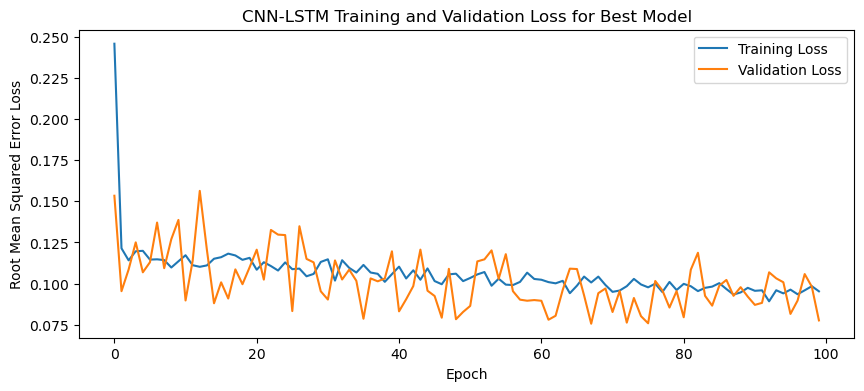

19/19 [==============================] - 2s 84ms/step - loss: 0.1015 - val_loss: 0.0830
Epoch 63/100
19/19 [==============================] - 2s 93ms/step - loss: 0.1024 - val_loss: 0.0992
Epoch 64/100
19/19 [==============================] - 2s 85ms/step - loss: 0.0992 - val_loss: 0.0991
Epoch 65/100
19/19 [==============================] - 2s 100ms/step - loss: 0.1047 - val_loss: 0.0633
Epoch 66/100
19/19 [==============================] - 2s 104ms/step - loss: 0.1023 - val_loss: 0.0930
Epoch 67/100
19/19 [==============================] - 2s 93ms/step - loss: 0.0991 - val_loss: 0.0574
Epoch 68/100
19/19 [==============================] - 2s 102ms/step - loss: 0.0987 - val_loss: 0.1029
Epoch 69/100
19/19 [==============================] - 2s 98ms/step - loss: 0.0962 - val_loss: 0.1001
Epoch 70/100
19/19 [==============================] - 2s 100ms/step - loss: 0.0937 - val_loss: 0.0971
Epoch 71/100
19/19 [==============================] - 2s 88ms/step - loss: 0.0993 - val_loss: 0.0653

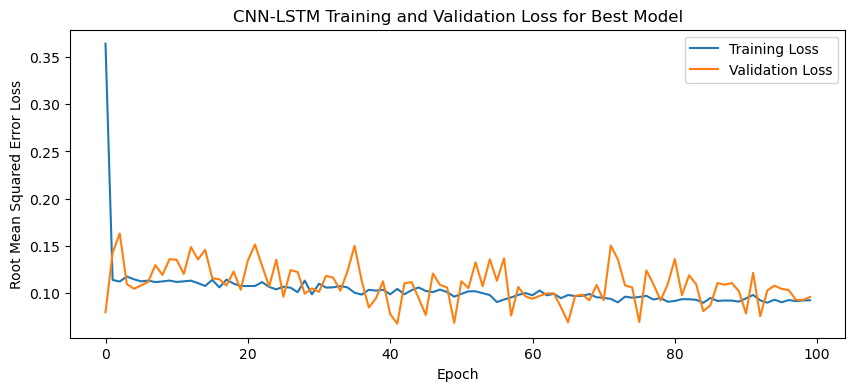

1/1 - 2s - loss: 0.0701 - 2s/epoch - 2s/step
Test Loss: 0.0700601264834404


In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit an LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):

    cv_accuracies = []
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "CNN-LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

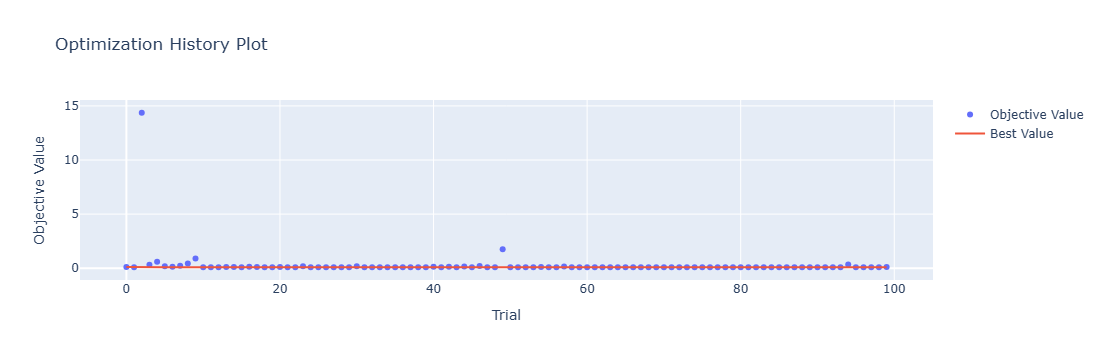

In [4]:
optuna.visualization.plot_optimization_history(study)

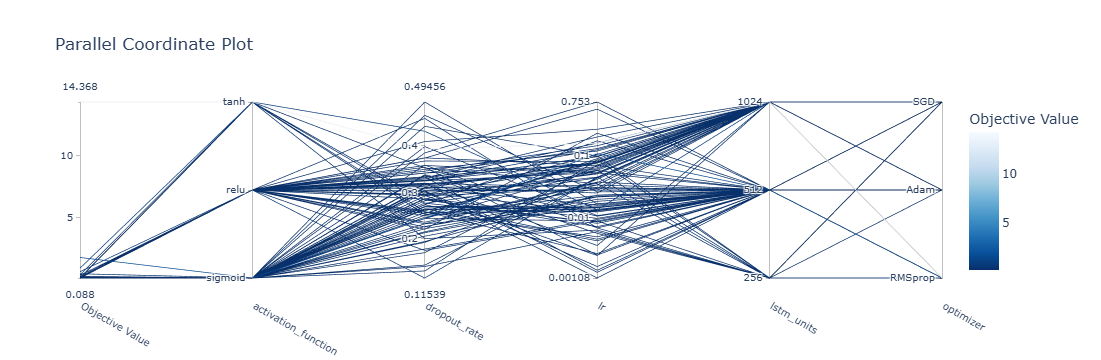

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

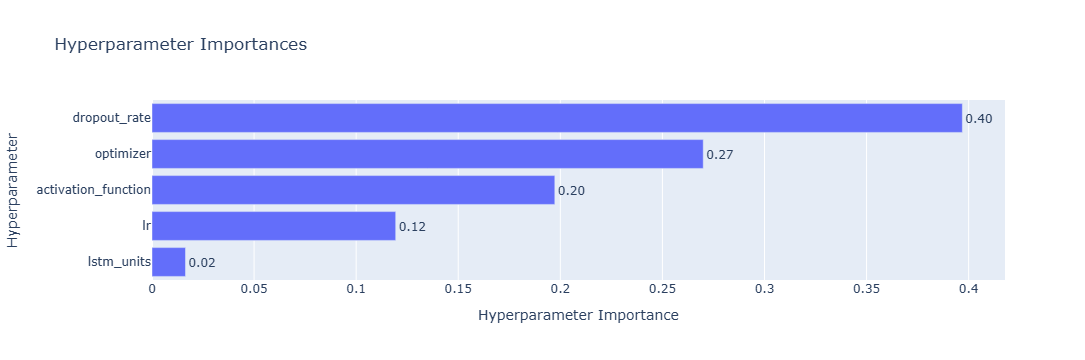

In [6]:
optuna.visualization.plot_param_importances(study)

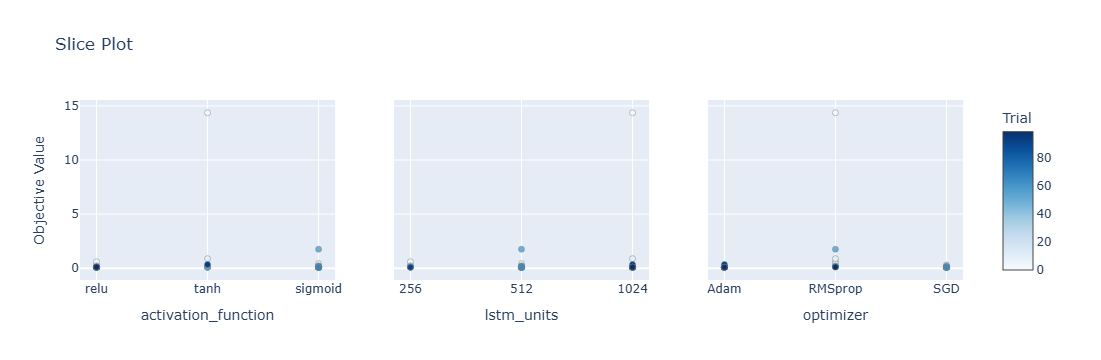

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

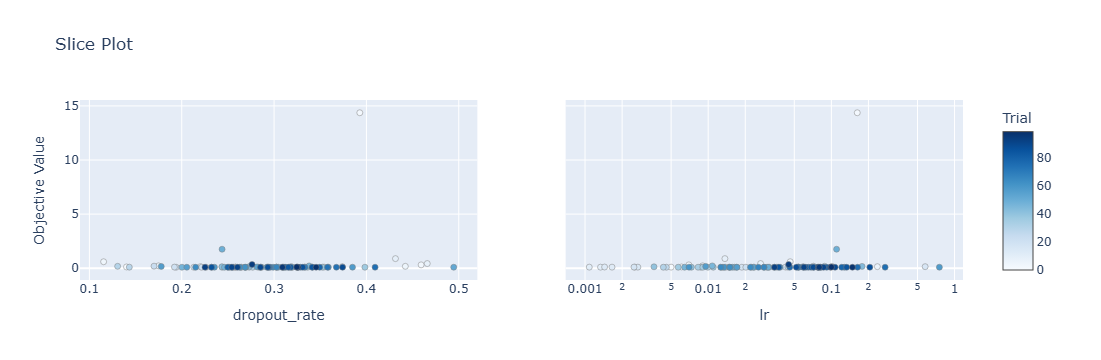

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate'])

[[12.82 12.33 12.14 11.9  12.75 12.05 11.96 11.88 11.66 11.6  11.21 11.85
  11.29 12.12 12.23 11.95 11.91 12.96 13.05 13.43 12.59 12.54 12.66 12.47
  12.18 12.49 13.25]
 [10.07  9.17  8.73  9.1   9.64  9.62  9.38  9.31  8.9   8.65  8.67  9.09
   8.97  9.33  9.58  9.53  9.17 10.25  9.66 10.33 10.45 10.26 10.47 10.03
   9.51  9.7  10.33]]
Epoch 1/100
19/19 [==============================] - 5s 80ms/step - loss: 0.2673 - accuracy: 0.3684 - mae: 0.2176 - rmse: 0.2673 - mape: 52.6395 - pearson: 0.1641 - val_loss: 0.0955 - val_accuracy: 0.3333 - val_mae: 0.0791 - val_rmse: 0.0955 - val_mape: 19.3984 - val_pearson: 0.3420
Epoch 2/100
19/19 [==============================] - 0s 11ms/step - loss: 0.1203 - accuracy: 0.2105 - mae: 0.1008 - rmse: 0.1203 - mape: 24.9437 - pearson: 0.1538 - val_loss: 0.1188 - val_accuracy: 0.0000e+00 - val_mae: 0.0960 - val_rmse: 0.1188 - val_mape: 23.7674 - val_pearson: 0.1285
Epoch 3/100
19/19 [==============================] - 0s 11ms/step - loss: 0.1183 - accura

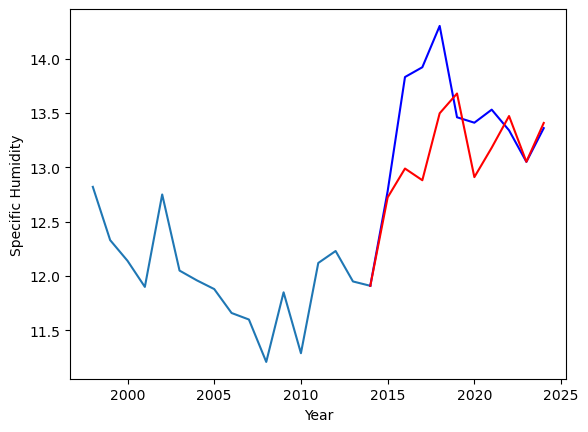

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
9.71		9.97		0.26
10.79		10.24		-0.55
10.20		10.13		-0.07
10.87		10.75		-0.12
10.99		10.93		-0.06
10.80		10.16		-0.64
11.01		10.43		-0.58
10.57		10.72		0.15
10.05		10.30		0.25
10.24		10.66		0.42


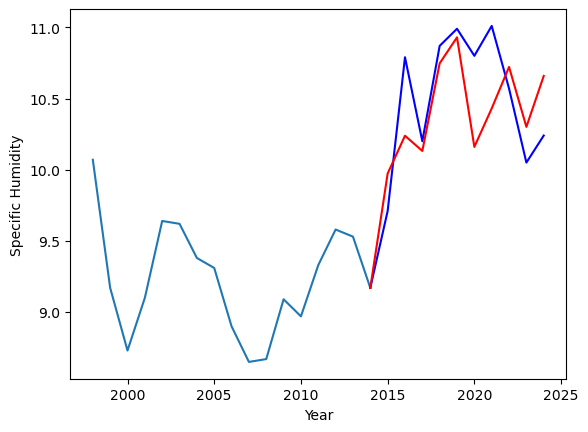

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   12.78  12.722736
1                1    9.71   9.973115


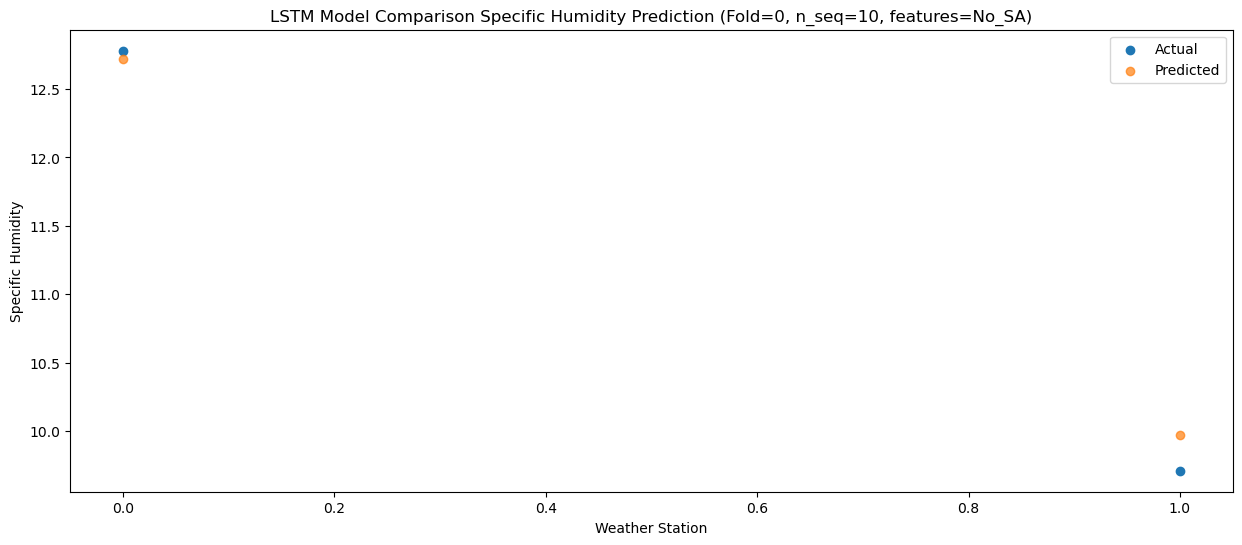

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   13.83  12.988374
1                1   10.79  10.238818


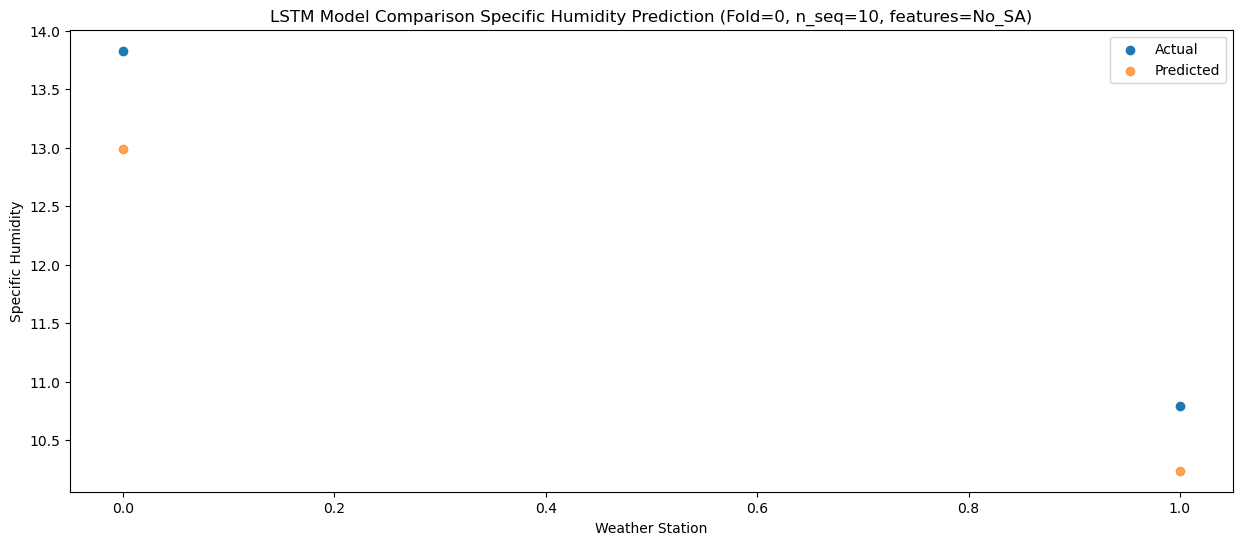

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   13.92  12.880872
1                1   10.20  10.131812


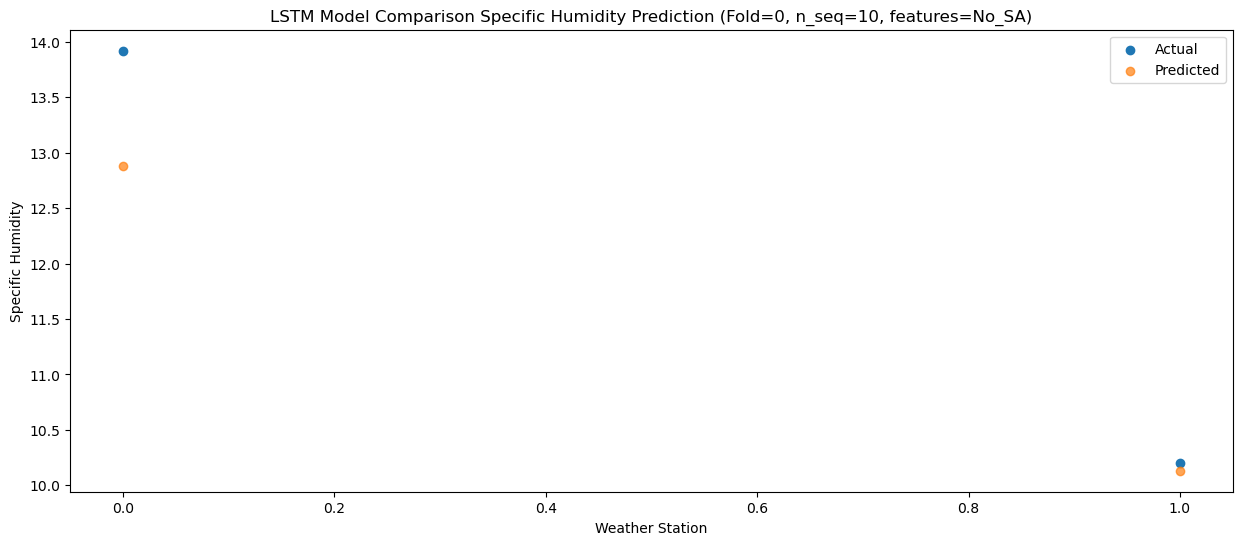

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   14.30  13.496573
1                1   10.87  10.747450


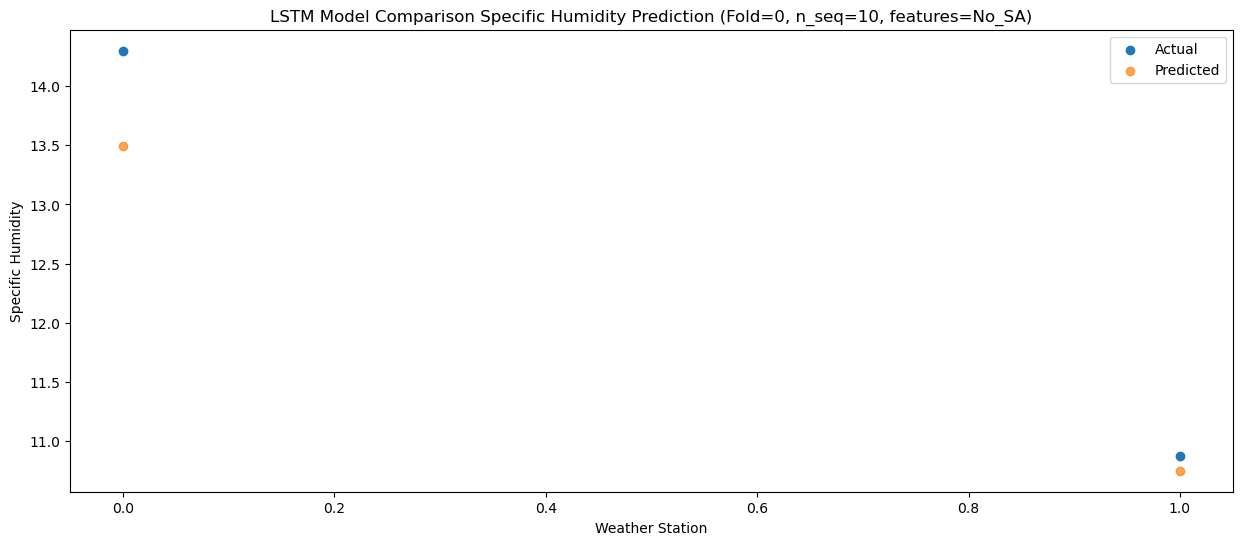

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   13.46  13.678568
1                1   10.99  10.929890


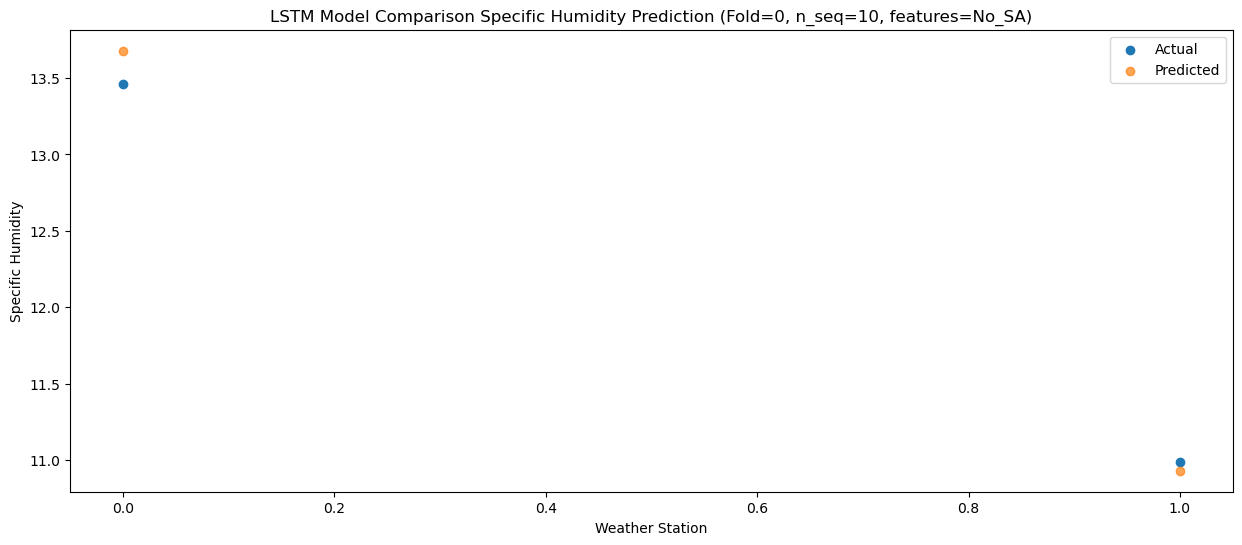

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   13.41  12.909468
1                1   10.80  10.160278


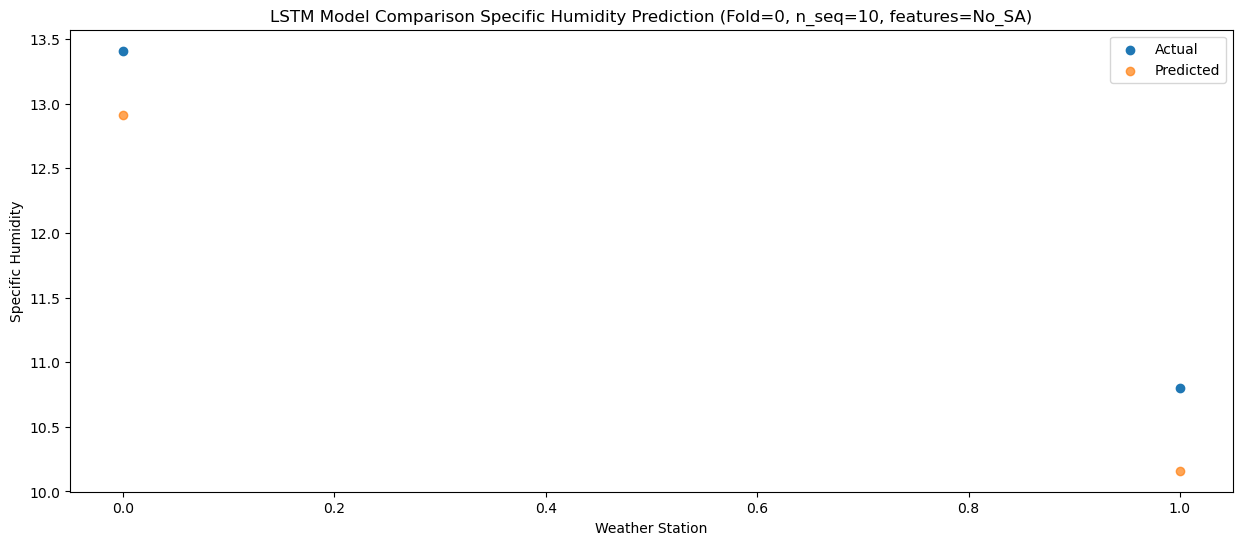

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   13.53  13.180099
1                1   11.01  10.430395


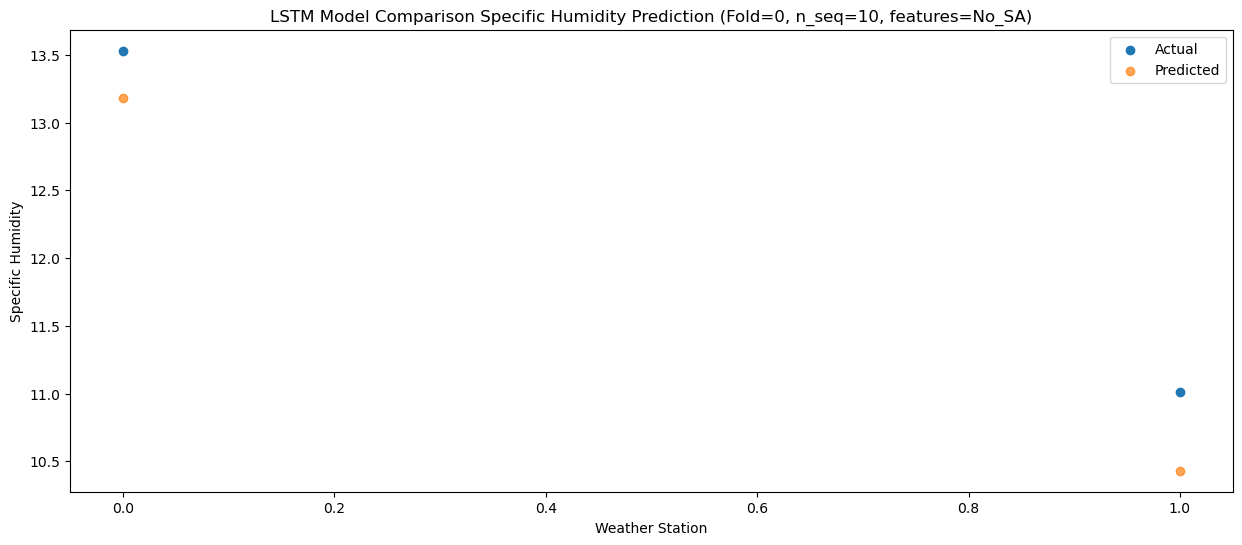

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   13.34  13.471272
1                1   10.57  10.721891


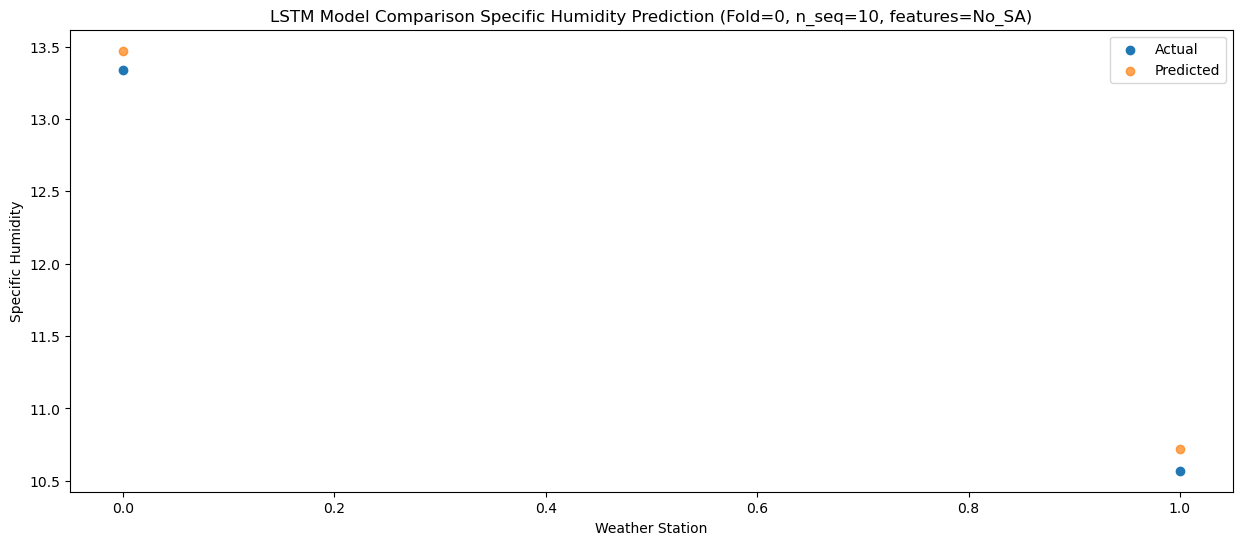

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   13.05  13.050659
1                1   10.05  10.300909


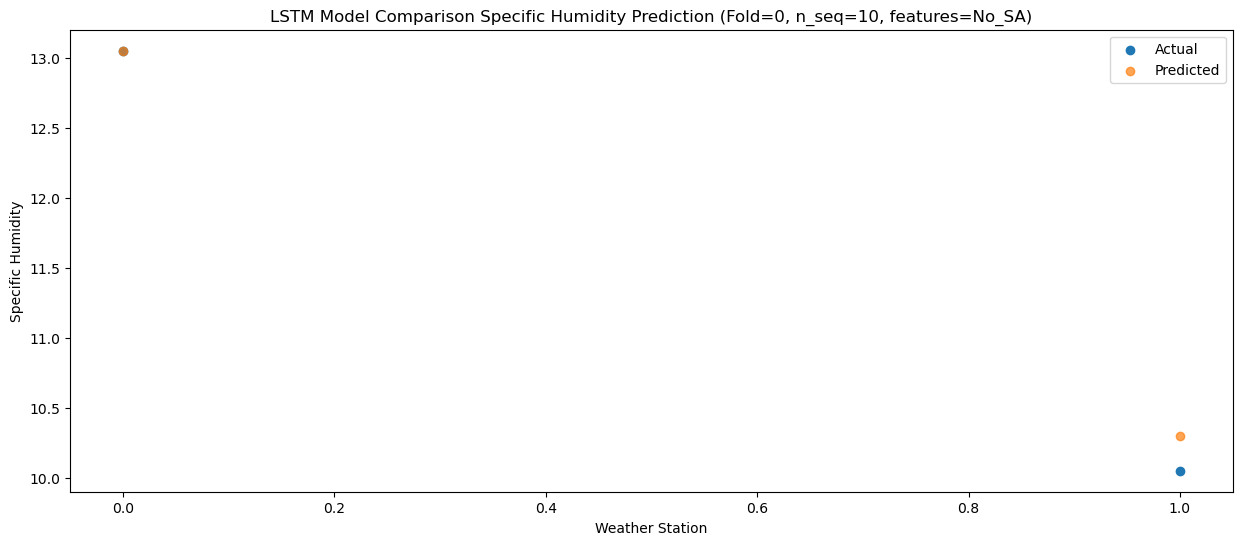

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   13.36  13.407594
1                1   10.24  10.658458


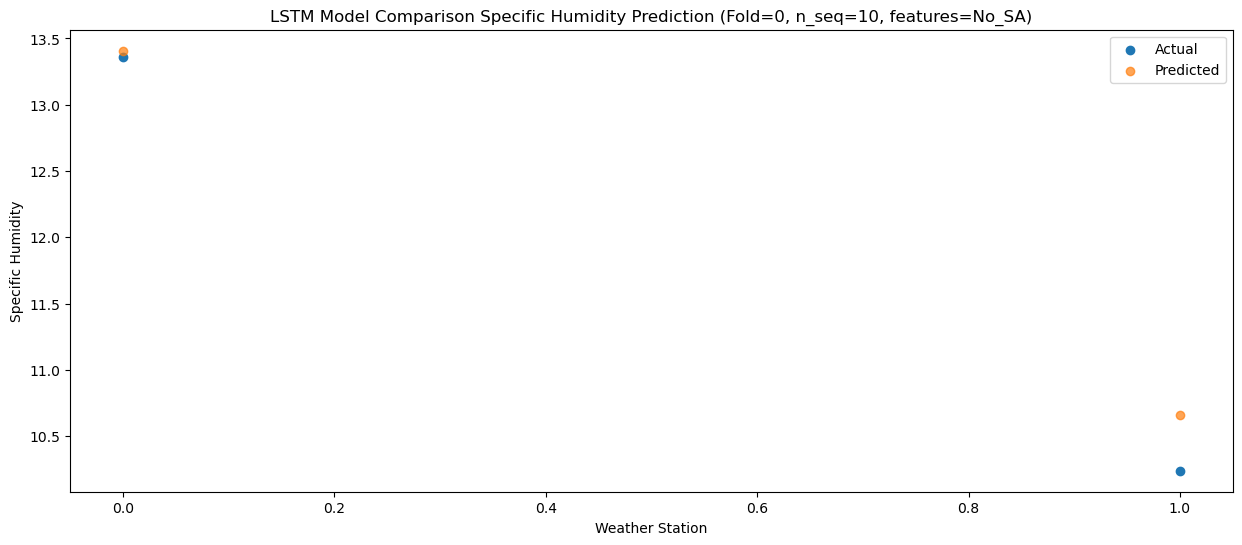

f, t:
[[12.78  9.71]
 [13.83 10.79]
 [13.92 10.2 ]
 [14.3  10.87]
 [13.46 10.99]
 [13.41 10.8 ]
 [13.53 11.01]
 [13.34 10.57]
 [13.05 10.05]
 [13.36 10.24]]
[[12.72273648  9.97311517]
 [12.98837441 10.2388184 ]
 [12.88087237 10.13181173]
 [13.49657261 10.7474504 ]
 [13.67856801 10.92988978]
 [12.90946776 10.16027794]
 [13.18009904 10.43039549]
 [13.47127214 10.72189108]
 [13.05065921 10.30090935]
 [13.40759429 10.65845782]]
Year at t+1:
t+1 SKRMSE: 0.190406
t+1 KRMSE: 0.190406
t+1 MAE: 0.160189
t+1 SKMAPE: 0.015789
t+1 R2_SCORE: 0.984613
t+1 KMAPE: 0.015789
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 11.245000
Year at t+2:
t+2 SKRMSE: 0.711384
t+2 KRMSE: 0.711384
t+2 MAE: 0.696404
t+2 SKMAPE: 0.055969
t+2 R2_SCORE: 0.780961
t+2 KMAPE: 0.055969
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 12.310000
Year at t+3:
t+3 SKRMSE: 0.736354
t+3 KRMSE: 0.736354
t+3 MAE: 0.553658
t+3 SKMAPE: 0.040668
t+3 R2_SCORE: 0.843271
t+3 KMAPE: 0.040668
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 12.060000
Year at 

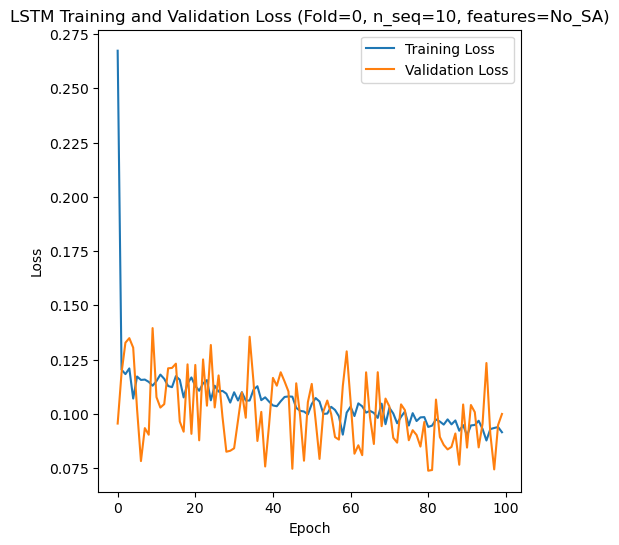

[[11.47 10.69 10.49 10.89 11.27 10.87 11.1  11.03 10.18 10.34 10.24 10.68
  10.6  10.94 10.76 10.47 10.42 11.26 10.81 11.26 11.81 11.14 11.5  10.83
  10.88 10.74 11.48]
 [ 7.63  7.36  7.16  7.53  7.72  7.87  8.49  7.73  6.89  8.03  6.62  6.93
   7.69  5.78  7.04  6.89  7.21  8.34  8.32  7.95  7.79  7.82  7.08  7.52
   6.95  7.1   7.65]]
Epoch 1/100
19/19 [==============================] - 6s 100ms/step - loss: 0.3309 - accuracy: 0.3158 - mae: 0.2677 - rmse: 0.3309 - mape: 62.1189 - pearson: 0.1399 - val_loss: 0.1116 - val_accuracy: 0.6667 - val_mae: 0.0896 - val_rmse: 0.1116 - val_mape: 21.7242 - val_pearson: 0.1712
Epoch 2/100
19/19 [==============================] - 1s 35ms/step - loss: 0.1111 - accuracy: 0.4211 - mae: 0.0903 - rmse: 0.1111 - mape: 21.0429 - pearson: 0.1824 - val_loss: 0.0778 - val_accuracy: 0.0000e+00 - val_mae: 0.0639 - val_rmse: 0.0778 - val_mape: 14.1766 - val_pearson: 0.4816
Epoch 3/100
19/19 [==============================] - 0s 13ms/step - loss: 0.1092 - accur

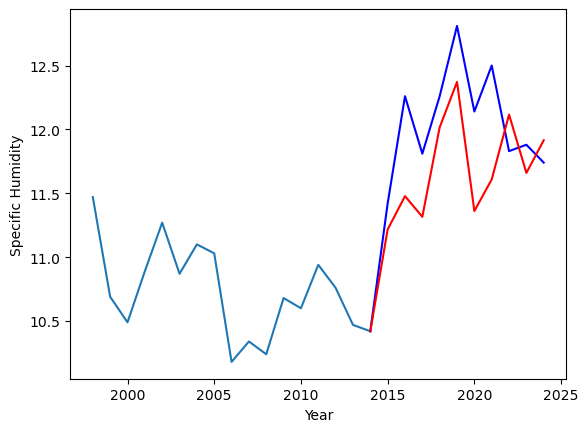

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.95		7.38		-0.57
9.08		7.64		-1.44
9.06		7.48		-1.58
8.69		8.18		-0.51
8.53		8.53		0.00
8.56		7.52		-1.04
7.82		7.77		-0.05
8.26		8.28		0.02
7.69		7.82		0.13
7.84		8.07		0.23


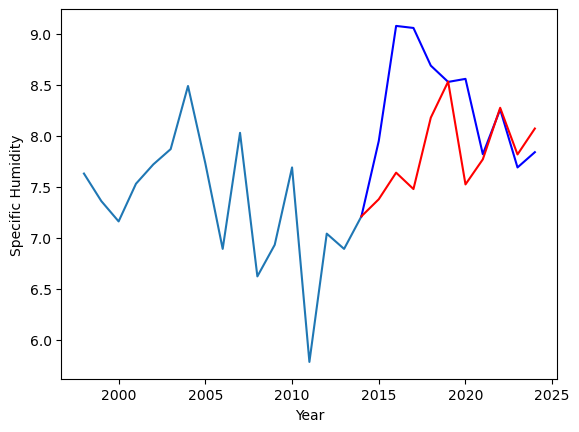

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   11.42  11.217169
1                1    7.95   7.377782


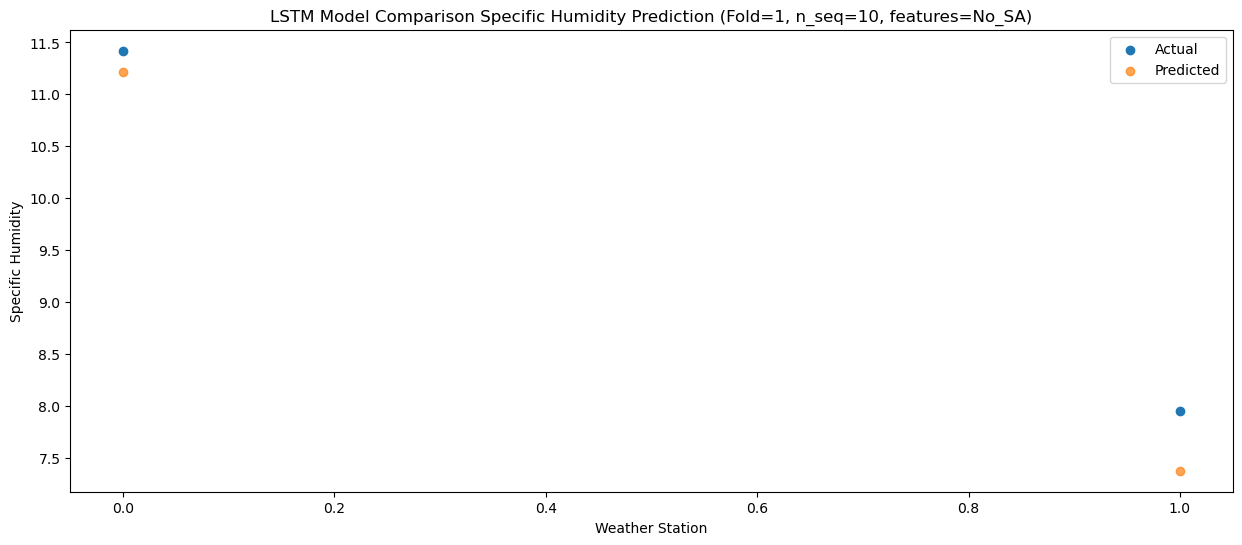

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   12.26  11.477543
1                1    9.08   7.638883


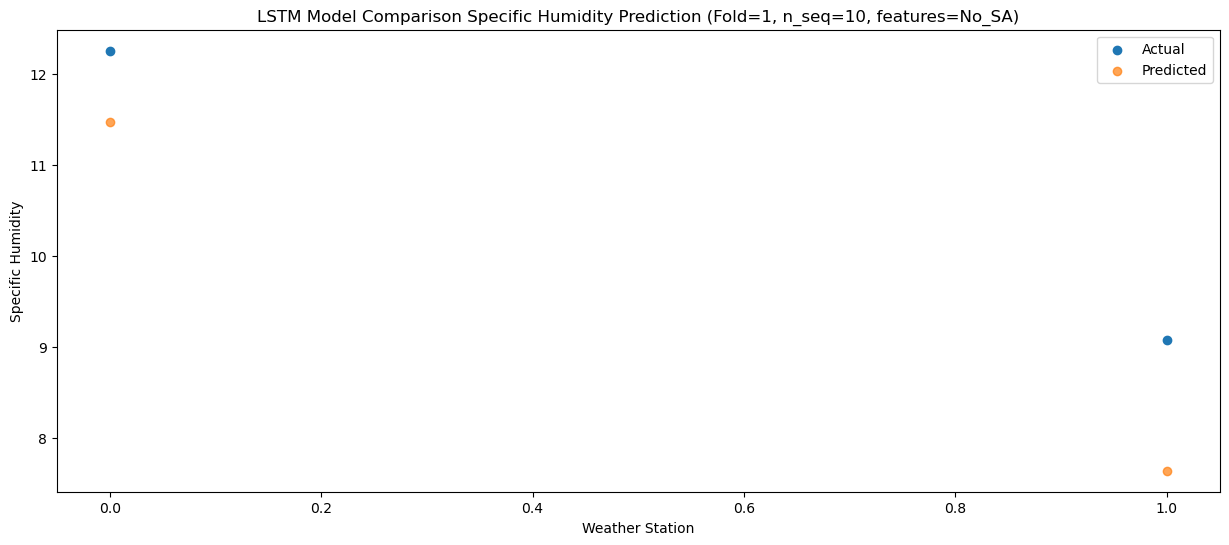

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   11.81  11.315988
1                1    9.06   7.477764


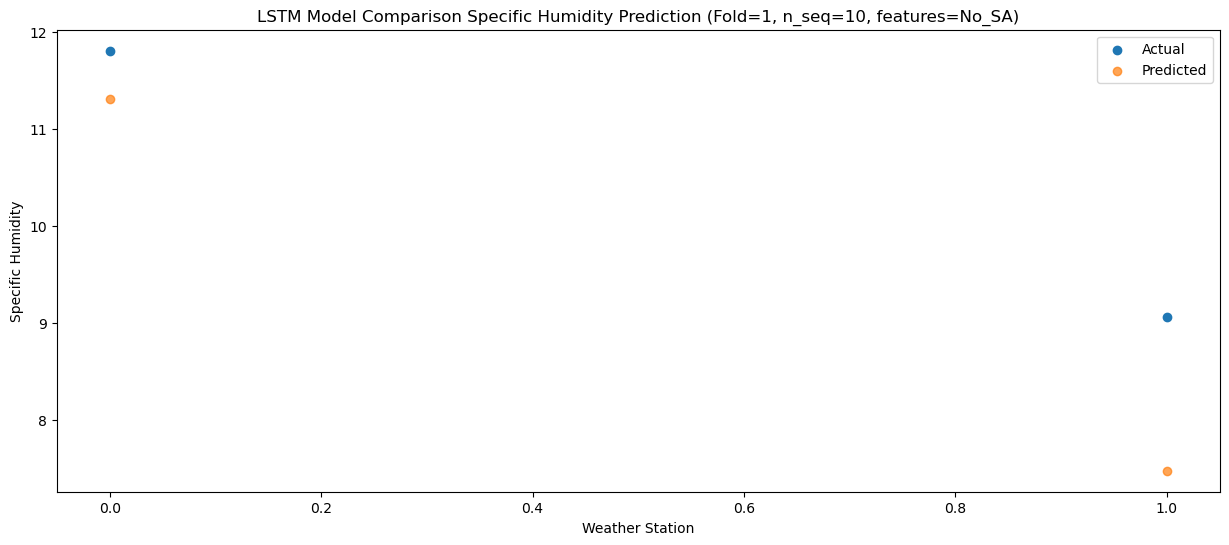

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   12.26  12.016587
1                1    8.69   8.178971


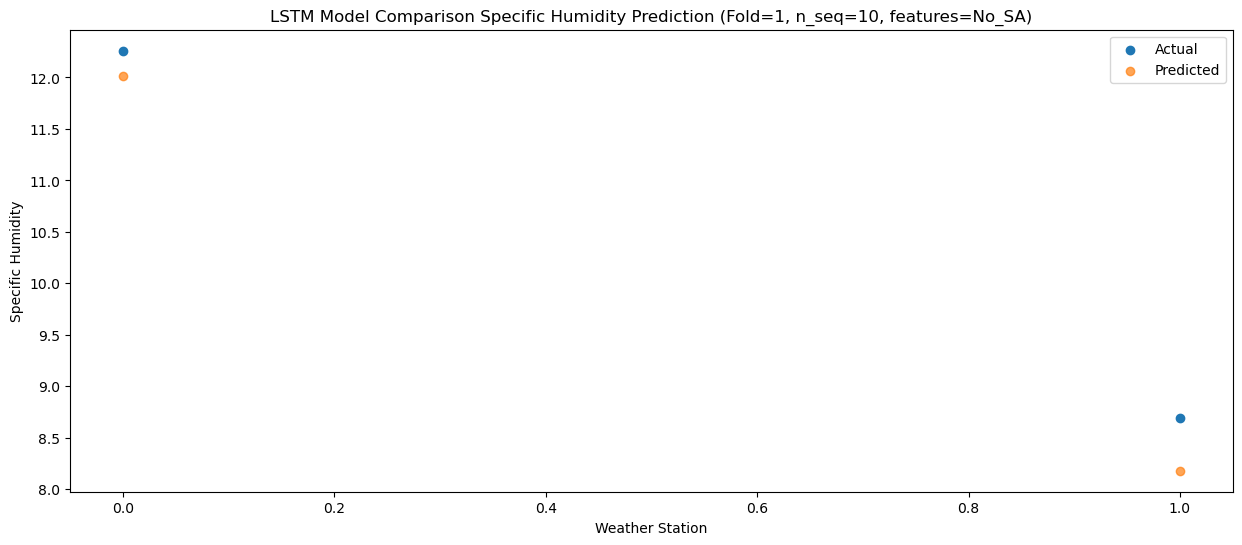

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   12.81  12.371548
1                1    8.53   8.533433


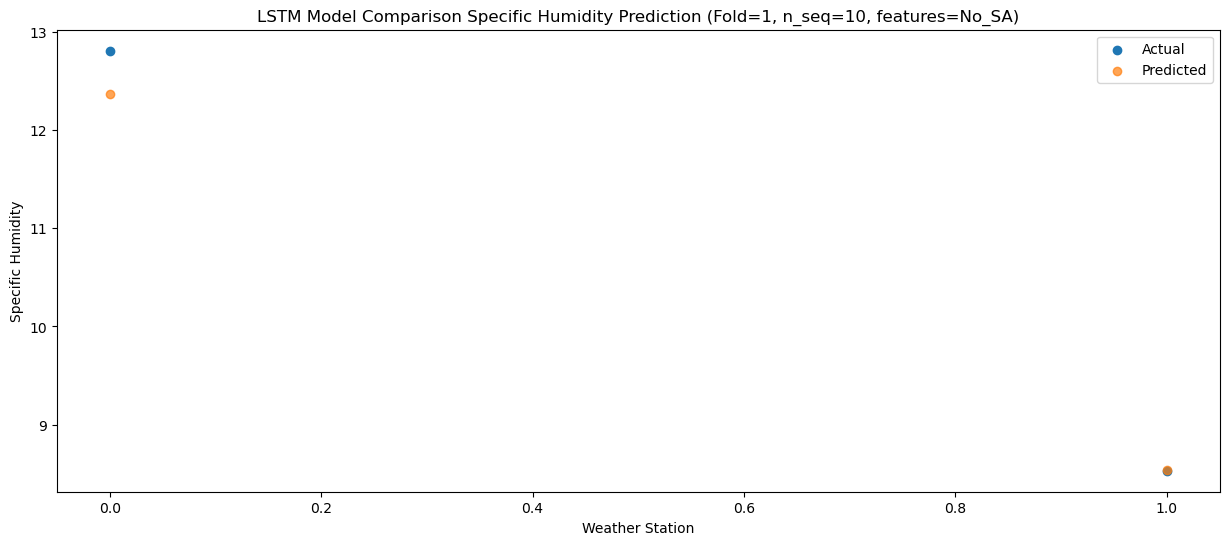

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   12.14  11.360950
1                1    8.56   7.523269


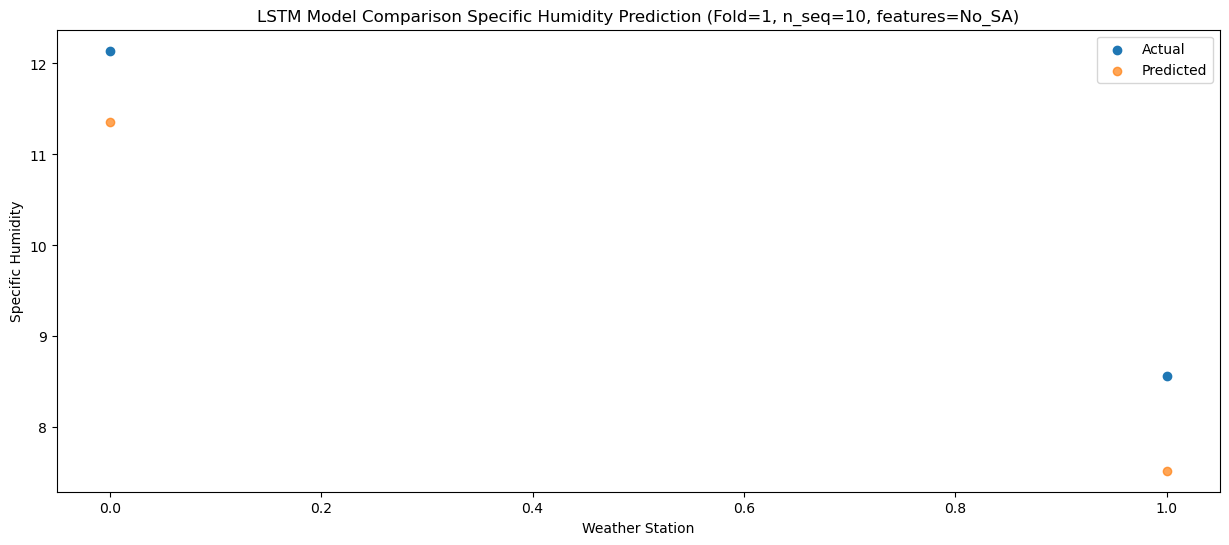

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   12.50  11.608364
1                1    7.82   7.769835


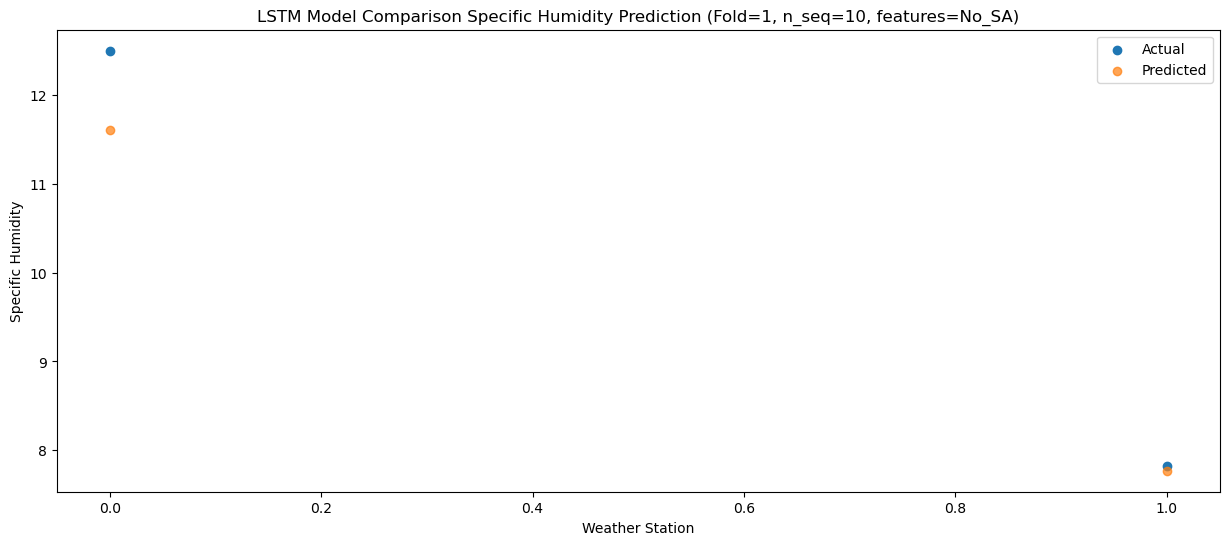

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   11.83  12.116046
1                1    8.26   8.275950


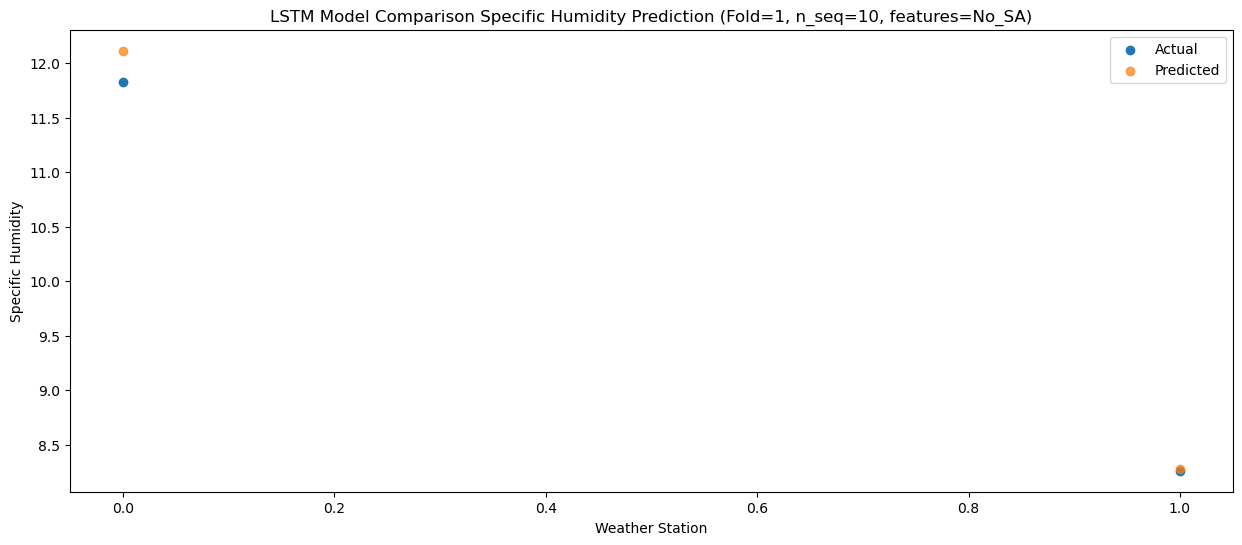

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   11.88  11.659495
1                1    7.69   7.817718


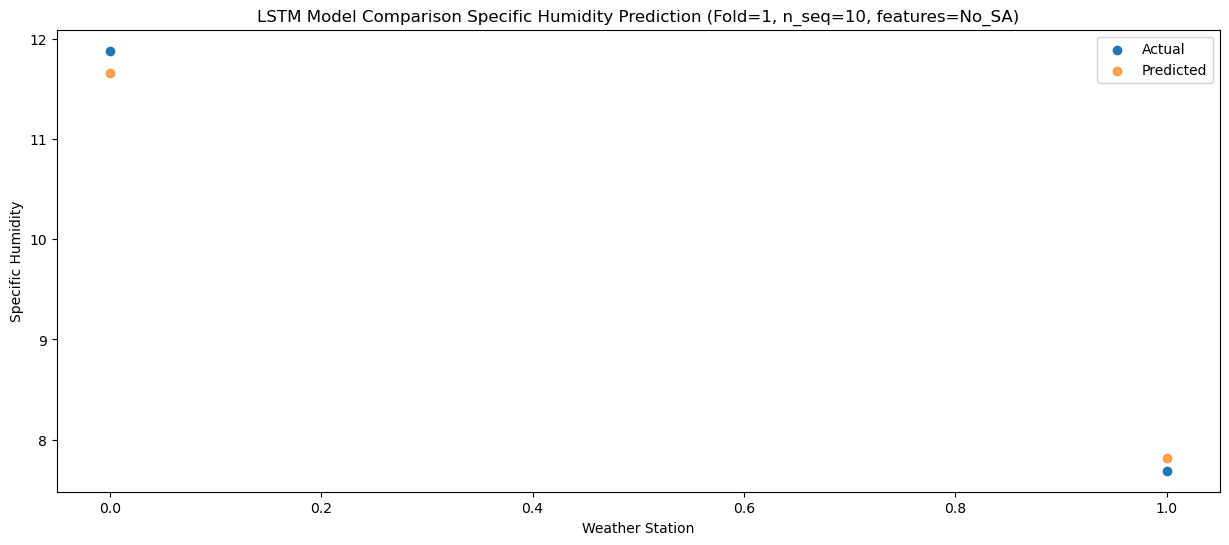

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   11.74  11.914965
1                1    7.84   8.072216


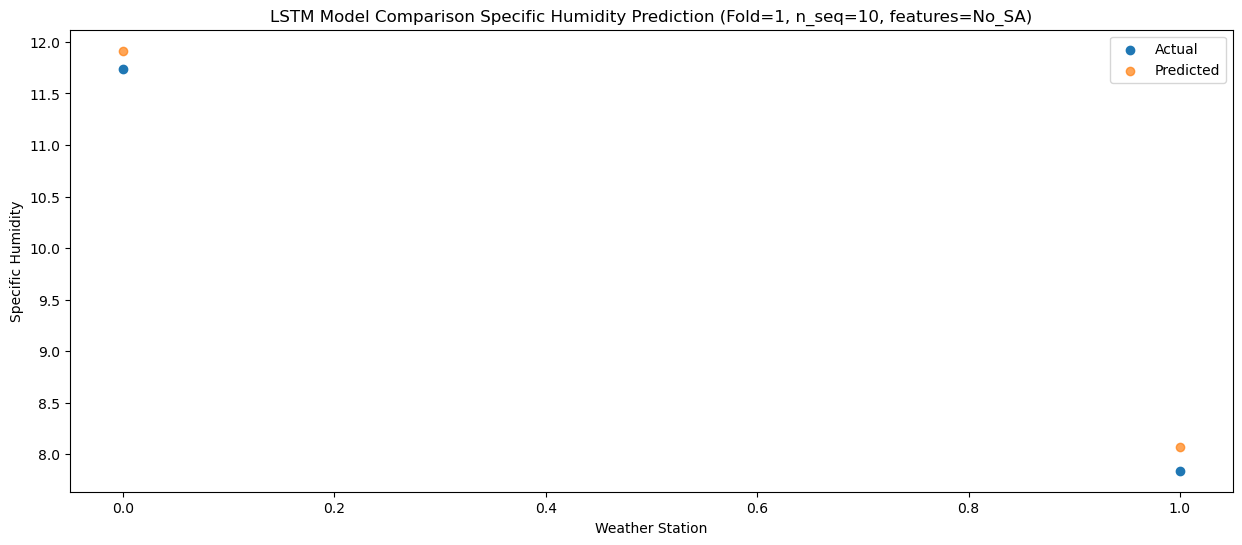

f, t:
[[11.42  7.95]
 [12.26  9.08]
 [11.81  9.06]
 [12.26  8.69]
 [12.81  8.53]
 [12.14  8.56]
 [12.5   7.82]
 [11.83  8.26]
 [11.88  7.69]
 [11.74  7.84]]
[[11.2171686   7.37778157]
 [11.47754279  7.63888279]
 [11.31598835  7.47776376]
 [12.01658689  8.17897098]
 [12.37154757  8.53343319]
 [11.36095034  7.52326893]
 [11.60836354  7.7698347 ]
 [12.1160458   8.2759496 ]
 [11.65949538  7.81771812]
 [11.91496486  8.07221556]]
Year at t+1:
t+1 SKRMSE: 0.429287
t+1 KRMSE: 0.429287
t+1 MAE: 0.387525
t+1 SKMAPE: 0.044869
t+1 R2_SCORE: 0.938780
t+1 KMAPE: 0.044869
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 9.685000
Year at t+2:
t+2 SKRMSE: 1.159538
t+2 KRMSE: 1.159538
t+2 MAE: 1.111787
t+2 SKMAPE: 0.111268
t+2 R2_SCORE: 0.468166
t+2 KMAPE: 0.111268
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 10.670000
Year at t+3:
t+3 SKRMSE: 1.172075
t+3 KRMSE: 1.172075
t+3 MAE: 1.038124
t+3 SKMAPE: 0.108235
t+3 R2_SCORE: 0.273383
t+3 KMAPE: 0.108235
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 10.435000
Year at t

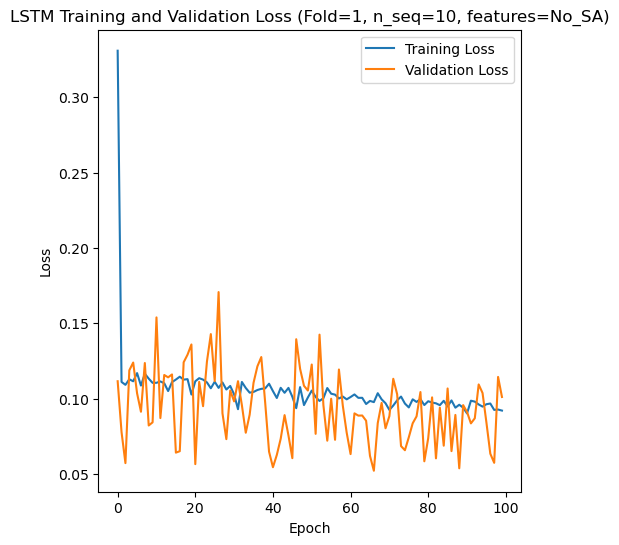

[[ 9.91  9.14  8.93  8.85  8.98  9.08  8.94  8.84  8.35  8.13  8.01  8.88
   8.79  8.86  9.22  8.7   8.51  9.48  9.05  9.73 10.13  9.86  9.33  8.92
   8.82  9.09  9.65]
 [ 8.49  7.33  7.71  7.76  7.77  7.75  7.45  7.41  7.43  7.25  7.05  7.35
   7.52  7.92  7.47  7.81  7.    7.75  8.3   8.25  8.35  7.7   7.52  7.59
   7.86  7.87  8.55]]
Epoch 1/100
19/19 [==============================] - 7s 74ms/step - loss: 0.2156 - accuracy: 0.4737 - mae: 0.1702 - rmse: 0.2156 - mape: 39.2960 - pearson: 0.2096 - val_loss: 0.1557 - val_accuracy: 0.3333 - val_mae: 0.1266 - val_rmse: 0.1557 - val_mape: 31.2644 - val_pearson: 0.0390
Epoch 2/100
19/19 [==============================] - 0s 12ms/step - loss: 0.1202 - accuracy: 0.3684 - mae: 0.0996 - rmse: 0.1202 - mape: 23.6980 - pearson: 0.2005 - val_loss: 0.0958 - val_accuracy: 0.0000e+00 - val_mae: 0.0808 - val_rmse: 0.0958 - val_mape: 20.3953 - val_pearson: 0.0949
Epoch 3/100
19/19 [==============================] - 0s 12ms/step - loss: 0.1057 - accura

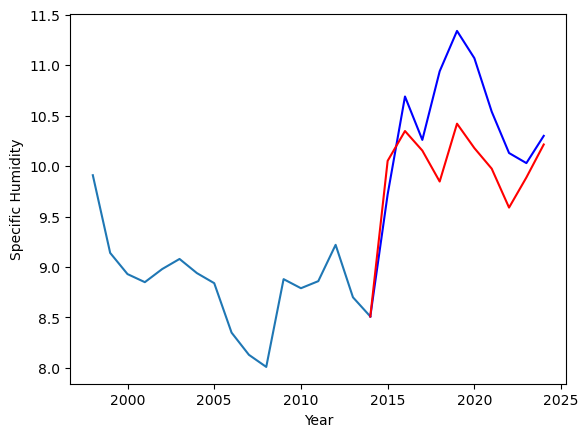

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.68		8.63		0.95
8.43		8.93		0.50
8.98		8.73		-0.25
8.93		8.43		-0.50
9.03		9.00		-0.03
8.38		8.76		0.38
8.20		8.56		0.36
8.27		8.17		-0.10
8.54		8.47		-0.07
8.55		8.80		0.25


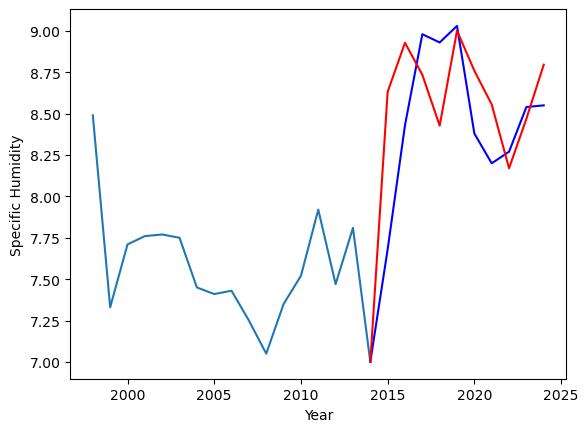

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0    9.72  10.052179
1                1    7.68   8.631749


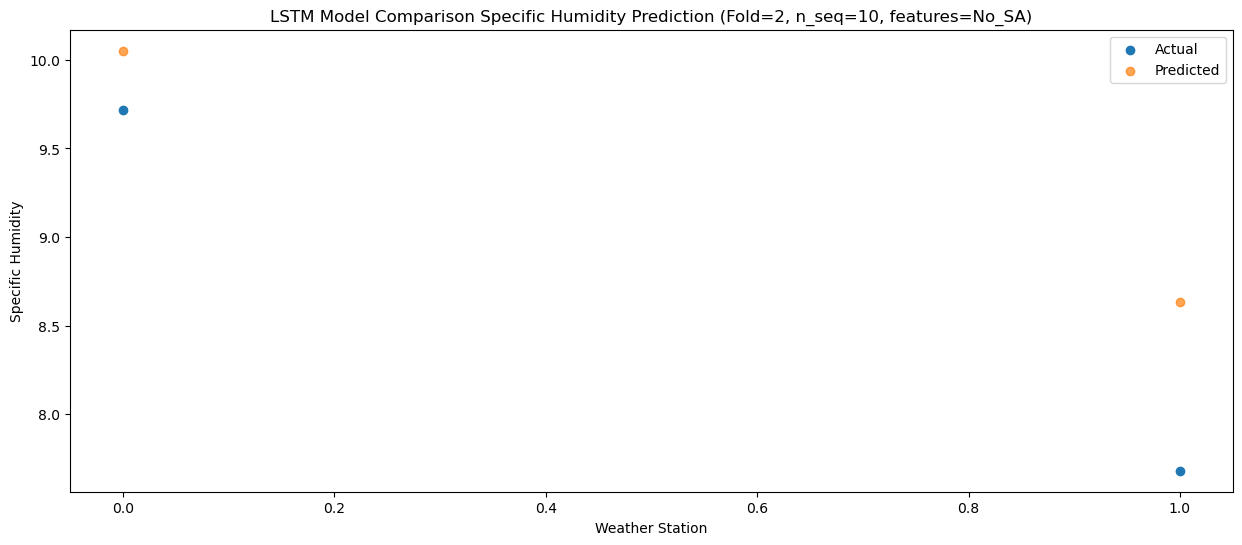

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   10.69  10.347793
1                1    8.43   8.928399


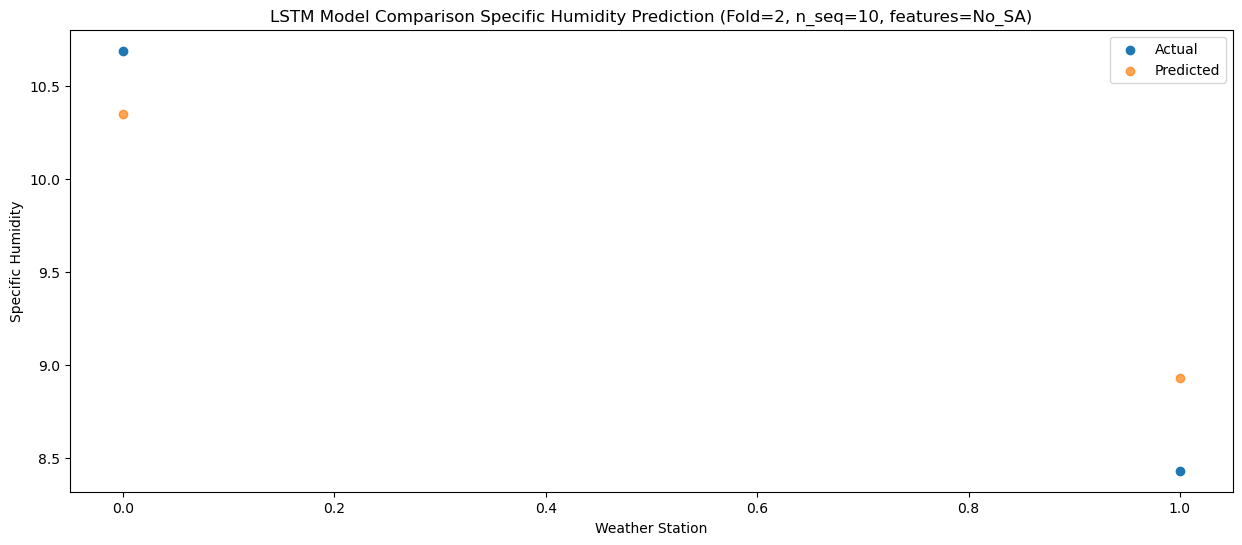

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   10.26  10.154045
1                1    8.98   8.734802


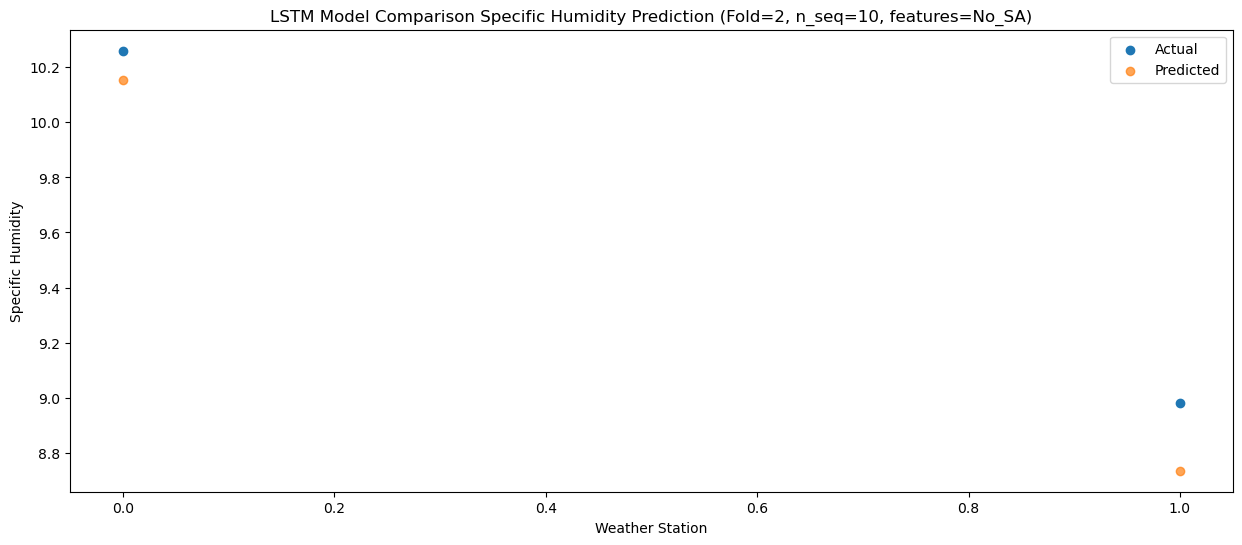

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   10.94   9.847333
1                1    8.93   8.427573


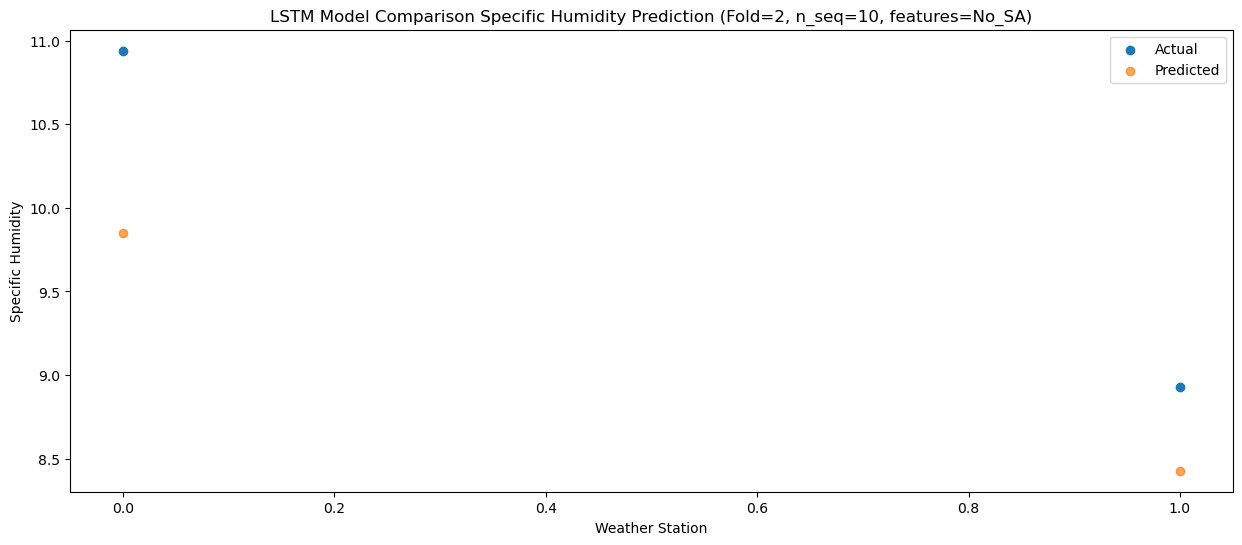

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   11.34  10.420754
1                1    9.03   9.001148


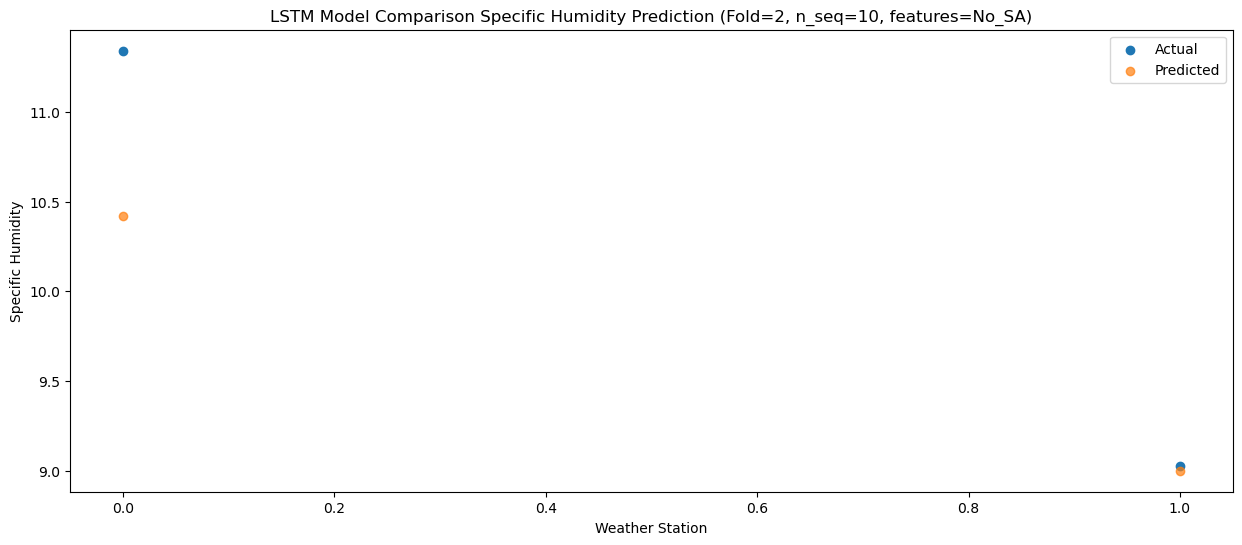

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   11.07  10.178926
1                1    8.38   8.759238


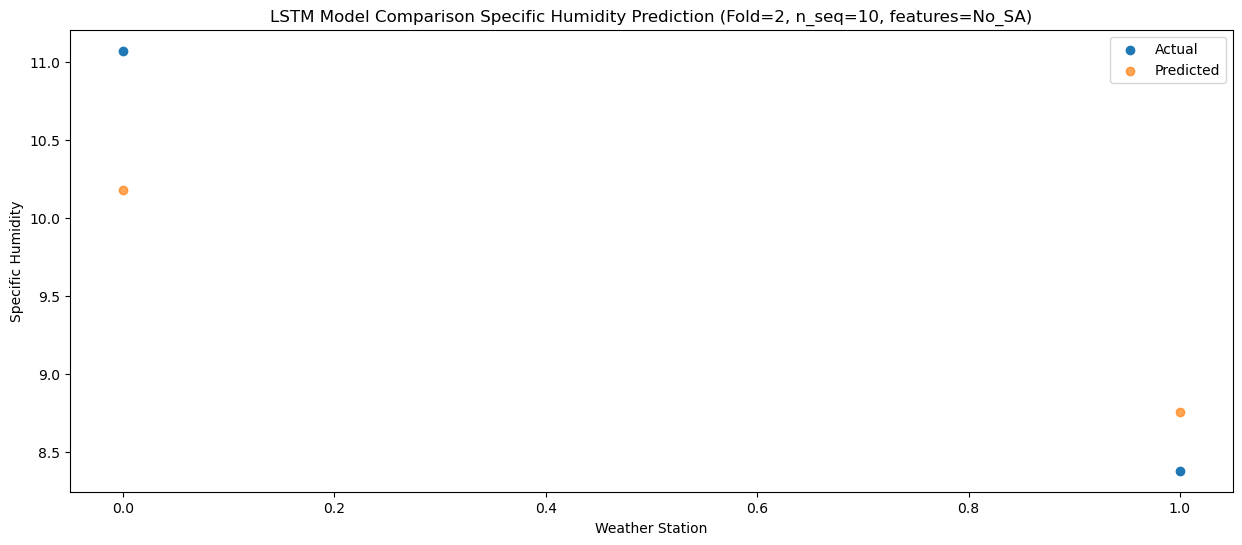

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   10.54   9.974973
1                1    8.20   8.555340


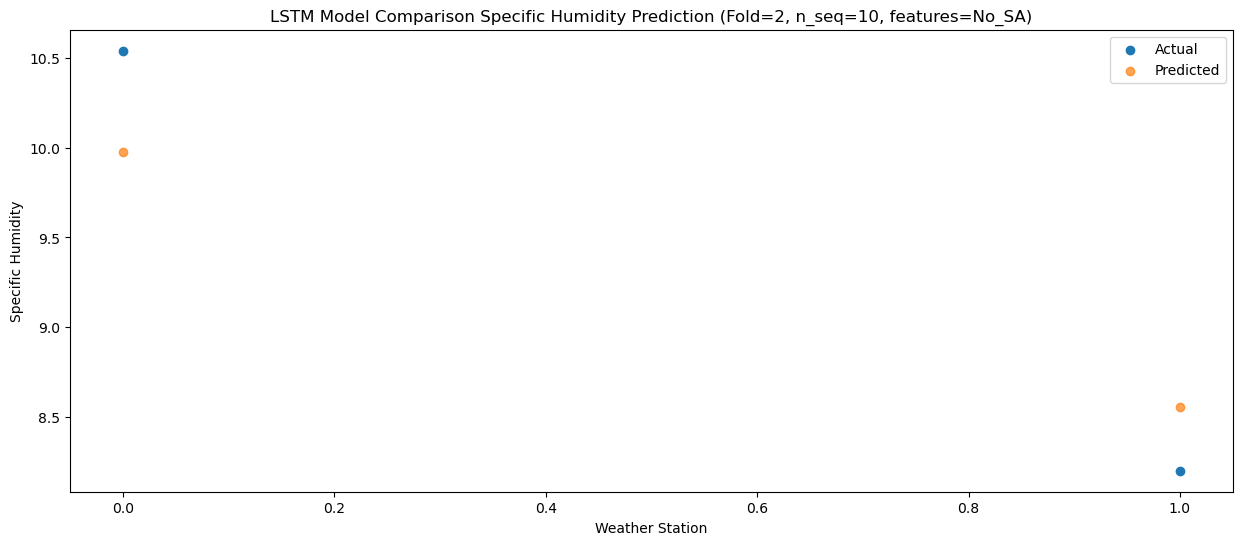

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   10.13   9.589210
1                1    8.27   8.169952


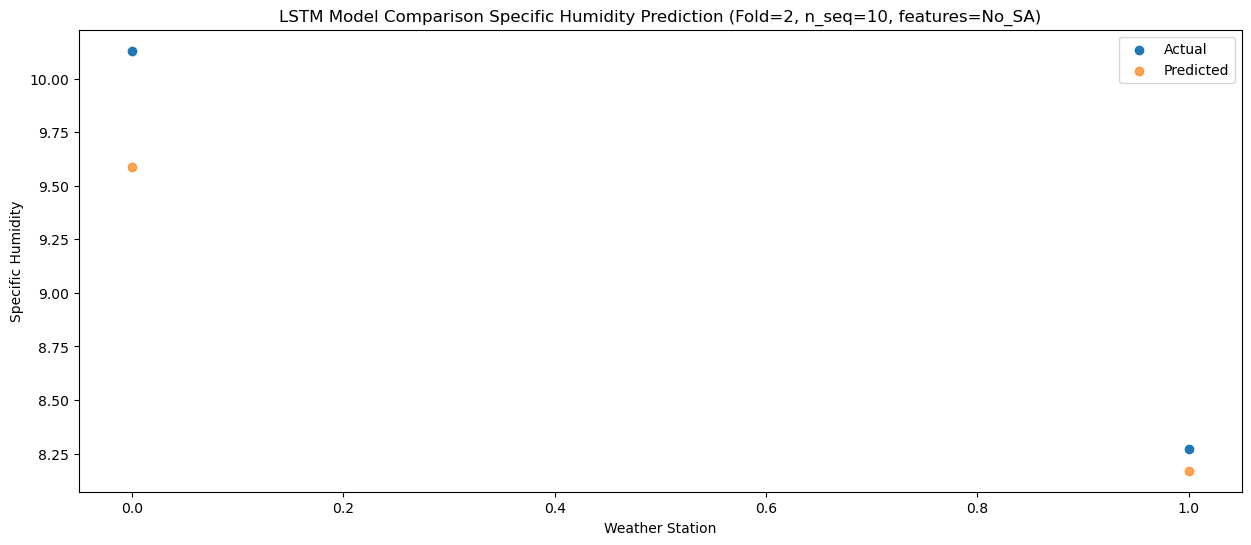

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   10.03   9.887694
1                1    8.54   8.468905


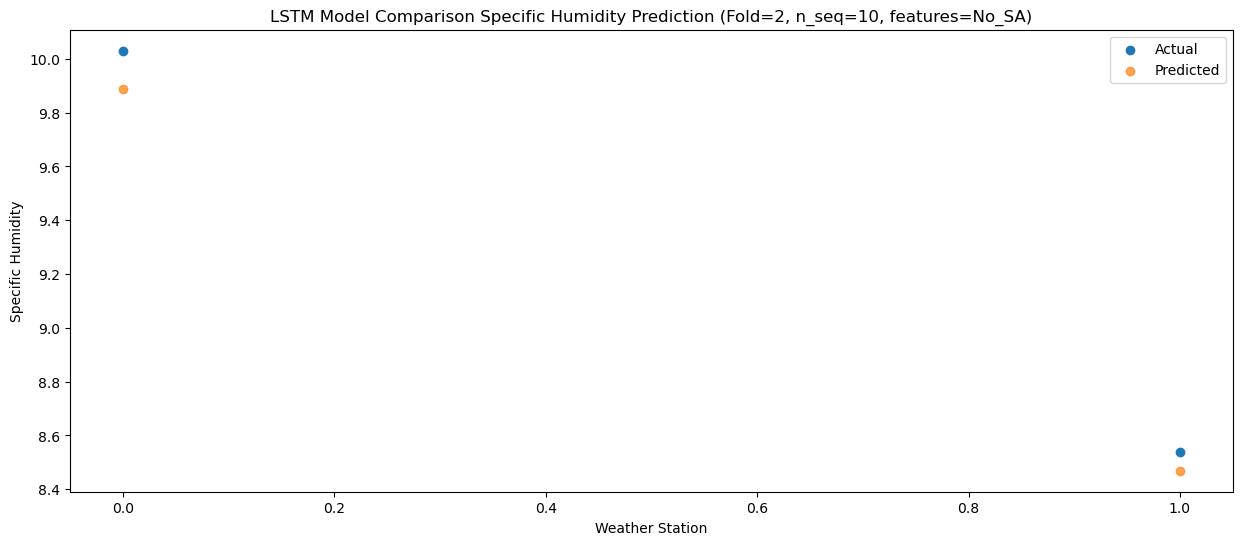

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   10.30  10.214416
1                1    8.55   8.795735


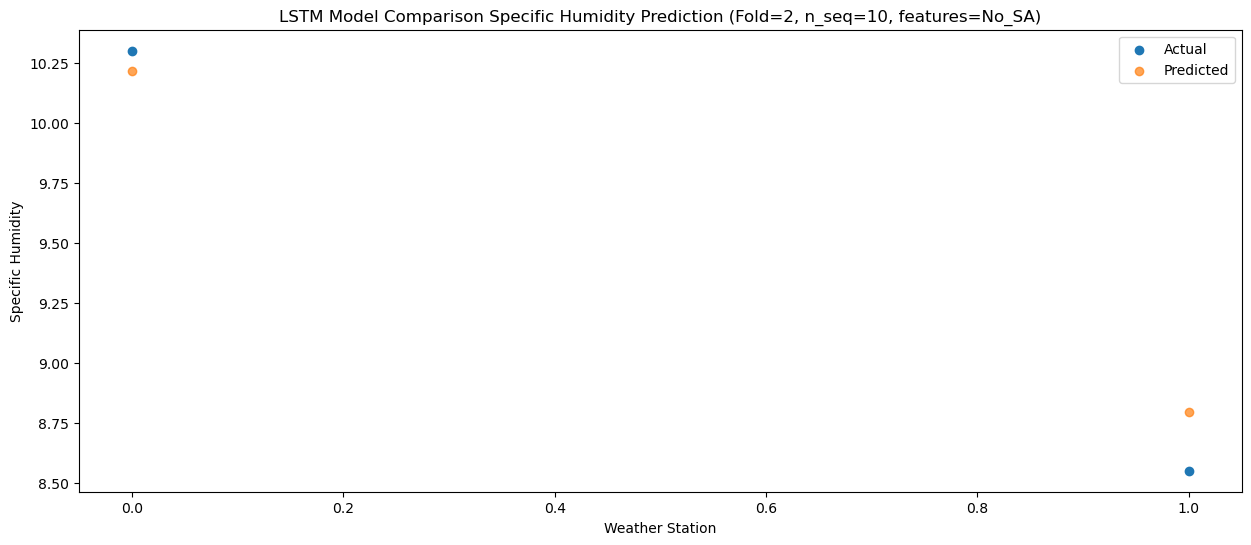

f, t:
[[ 9.72  7.68]
 [10.69  8.43]
 [10.26  8.98]
 [10.94  8.93]
 [11.34  9.03]
 [11.07  8.38]
 [10.54  8.2 ]
 [10.13  8.27]
 [10.03  8.54]
 [10.3   8.55]]
[[10.05217874  8.63174935]
 [10.34779328  8.9283986 ]
 [10.15404524  8.73480225]
 [ 9.84733297  8.42757306]
 [10.42075427  9.00114808]
 [10.17892649  8.75923753]
 [ 9.97497329  8.55534003]
 [ 9.58920965  8.16995216]
 [ 9.88769409  8.46890471]
 [10.21441555  8.79573507]]
Year at t+1:
t+1 SKRMSE: 0.712801
t+1 KRMSE: 0.712801
t+1 MAE: 0.641964
t+1 SKMAPE: 0.079050
t+1 R2_SCORE: 0.511645
t+1 KMAPE: 0.079050
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 8.700000
Year at t+2:
t+2 SKRMSE: 0.427497
t+2 KRMSE: 0.427497
t+2 MAE: 0.420303
t+2 SKMAPE: 0.045567
t+2 R2_SCORE: 0.856877
t+2 KMAPE: 0.045567
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 9.560000
Year at t+3:
t+3 SKRMSE: 0.188876
t+3 KRMSE: 0.188876
t+3 MAE: 0.175576
t+3 SKMAPE: 0.018816
t+3 R2_SCORE: 0.912905
t+3 KMAPE: 0.018816
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 9.620000
Year at t+4

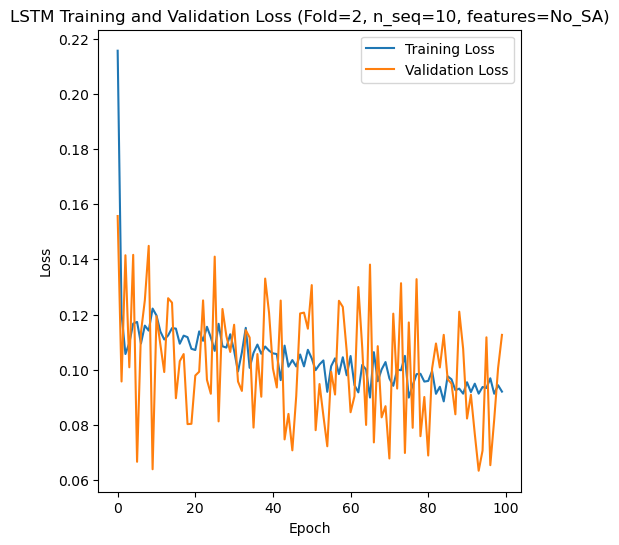

[[4.45 7.03 7.66 7.5  7.   7.5  6.8  7.19 6.85 6.32 6.46 6.61 7.06 6.53
  6.68 6.3  6.77 6.95 6.79 7.44 7.02 7.12 7.47 7.01 6.62 7.19 7.31]
 [8.33 7.39 7.85 8.23 8.15 7.91 8.01 7.7  7.52 7.54 7.12 7.57 7.71 8.23
  7.93 7.83 7.45 8.09 8.19 8.01 8.37 8.25 8.16 8.13 7.66 7.68 8.3 ]]
Epoch 1/100
20/20 [==============================] - 6s 87ms/step - loss: 0.2020 - accuracy: 0.2000 - mae: 0.1700 - rmse: 0.2020 - mape: 29.5749 - pearson: 0.1839 - val_loss: 0.1302 - val_accuracy: 0.5000 - val_mae: 0.1029 - val_rmse: 0.1302 - val_mape: 17.1641 - val_pearson: 0.2153
Epoch 2/100
20/20 [==============================] - 0s 10ms/step - loss: 0.1492 - accuracy: 0.3000 - mae: 0.1231 - rmse: 0.1492 - mape: 21.5410 - pearson: 0.1541 - val_loss: 0.1557 - val_accuracy: 0.5000 - val_mae: 0.1244 - val_rmse: 0.1557 - val_mape: 20.5125 - val_pearson: 0.0690
Epoch 3/100
20/20 [==============================] - 0s 10ms/step - loss: 0.1451 - accuracy: 0.3000 - mae: 0.1209 - rmse: 0.1451 - mape: 21.0659 - pear

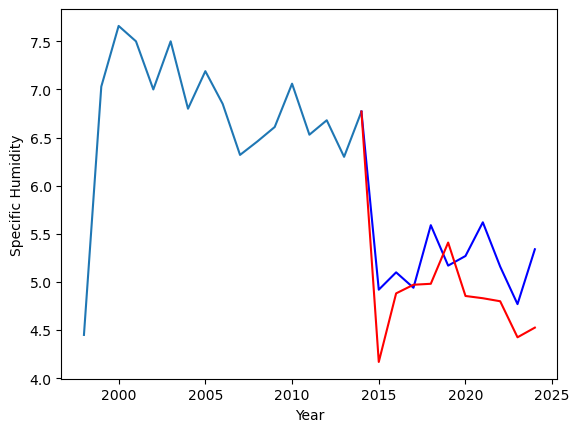

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.95		8.05		0.10
8.59		8.76		0.17
8.69		8.85		0.16
8.51		8.86		0.35
8.87		9.29		0.42
8.75		8.73		-0.02
8.66		8.71		0.05
8.63		8.68		0.05
8.16		8.30		0.14
8.18		8.41		0.23


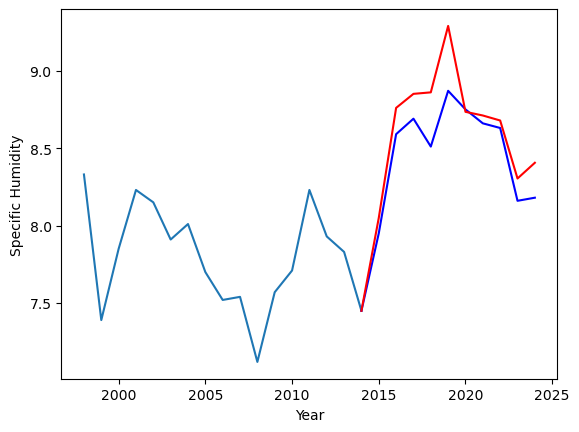

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0    4.92   4.169549
1                1    7.95   8.049686


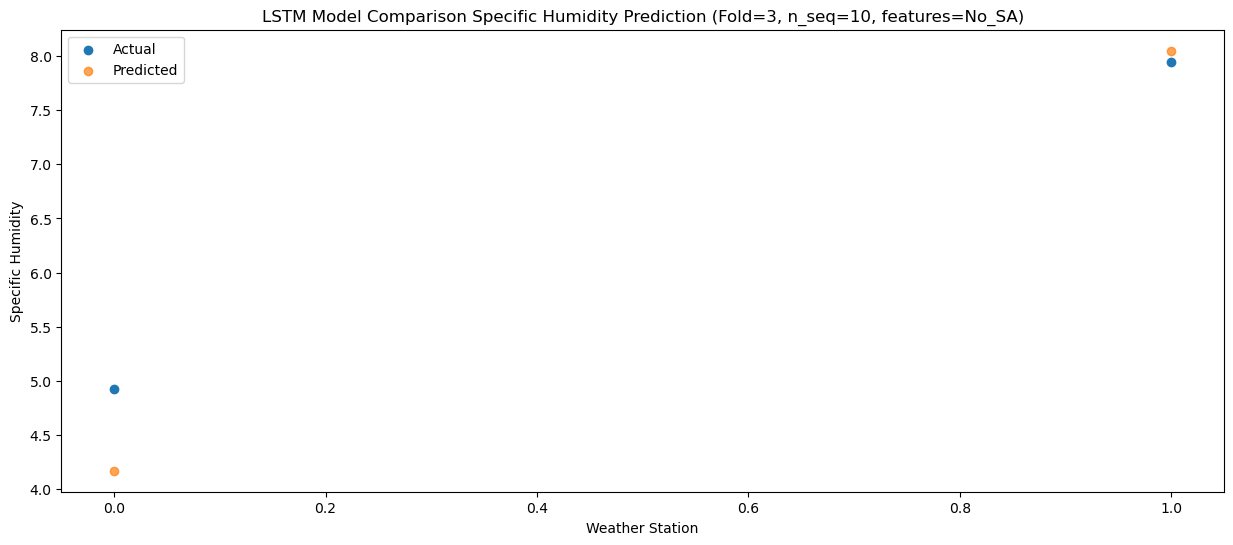

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0    5.10   4.881594
1                1    8.59   8.759750


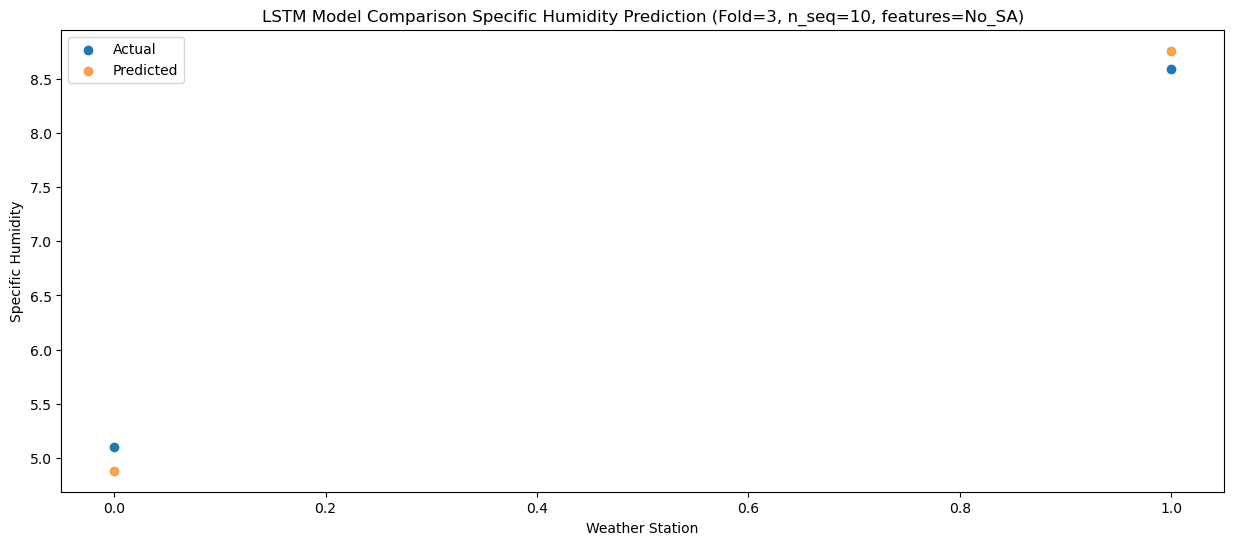

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0    4.94   4.971189
1                1    8.69   8.850310


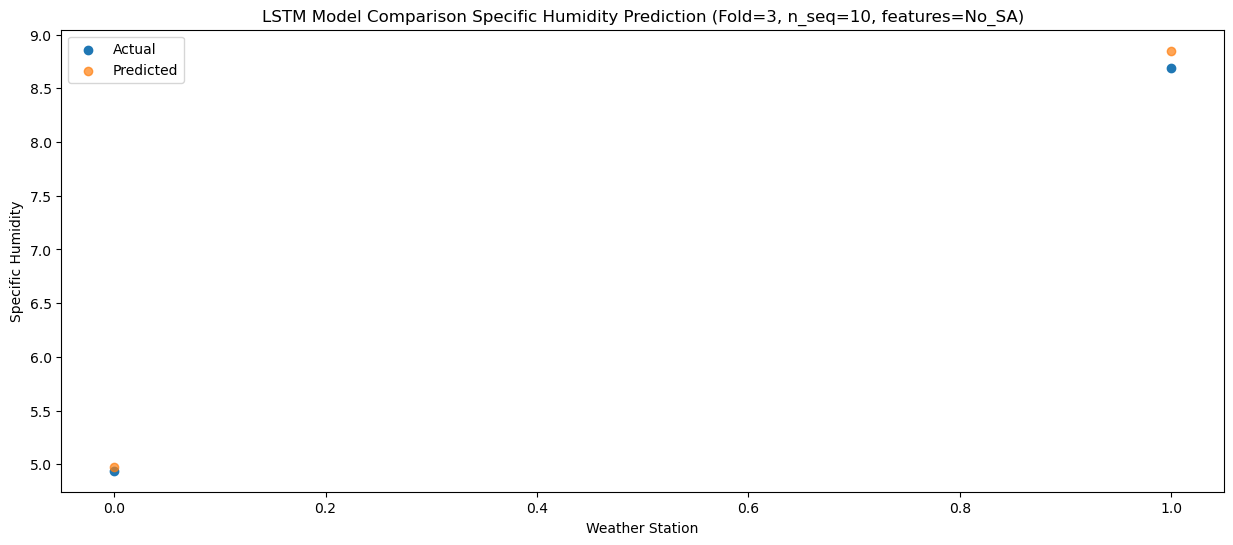

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0    5.59   4.981253
1                1    8.51   8.859979


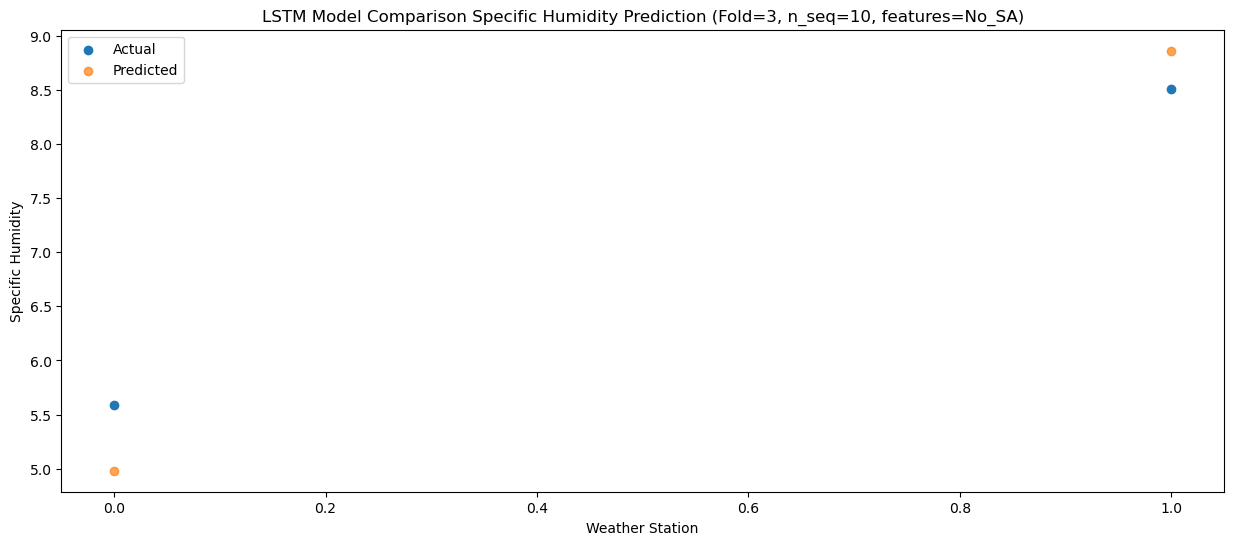

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0    5.17   5.409637
1                1    8.87   9.288802


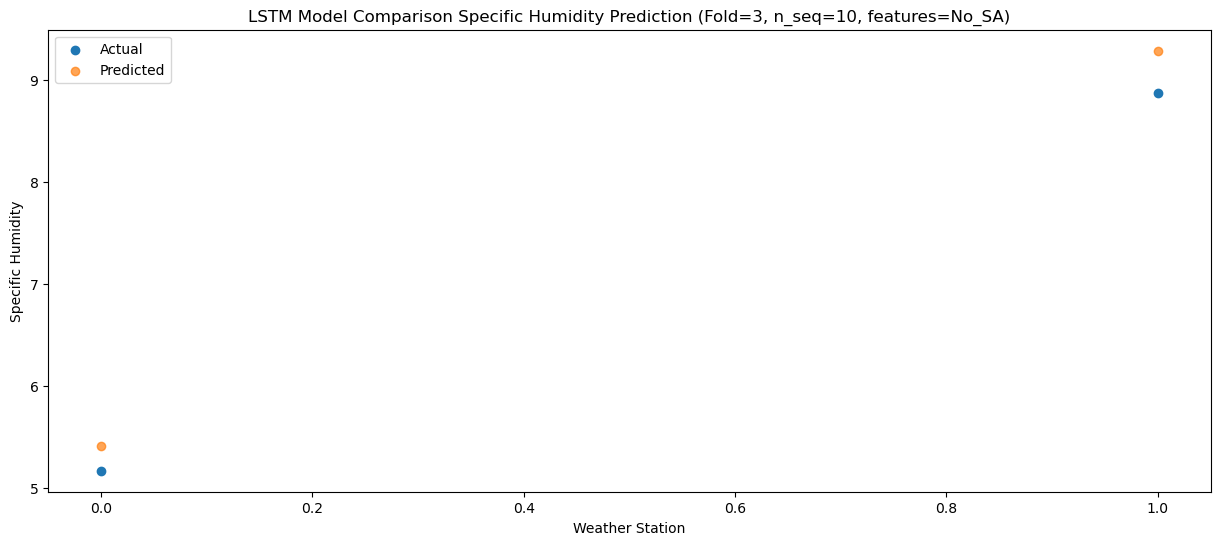

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0    5.27   4.854606
1                1    8.75   8.734274


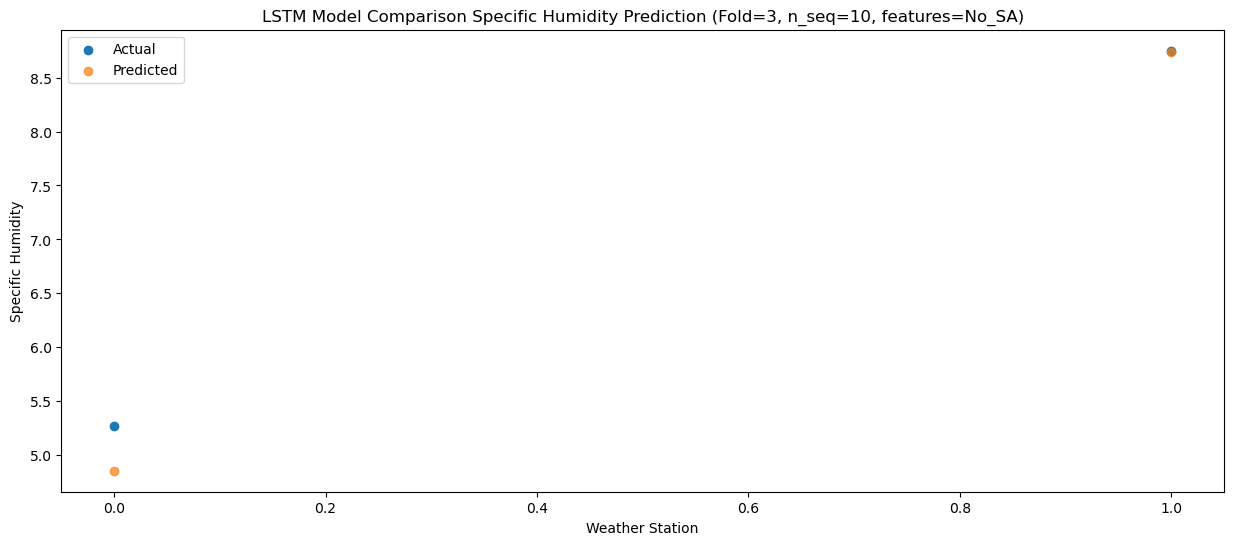

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0    5.62   4.831240
1                1    8.66   8.710622


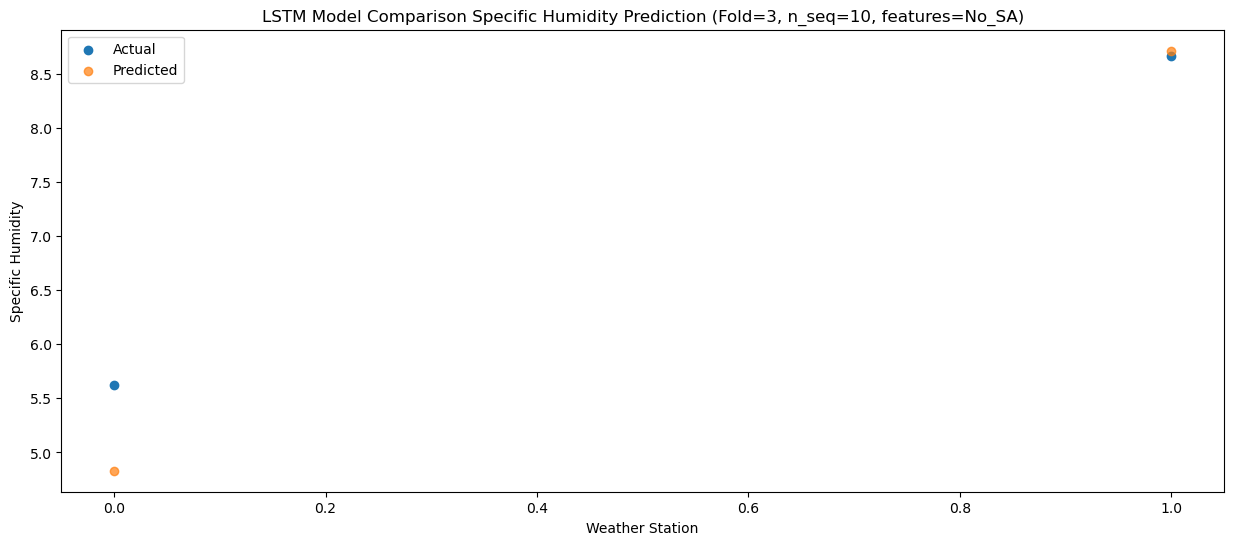

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0    5.16   4.799781
1                1    8.63   8.678272


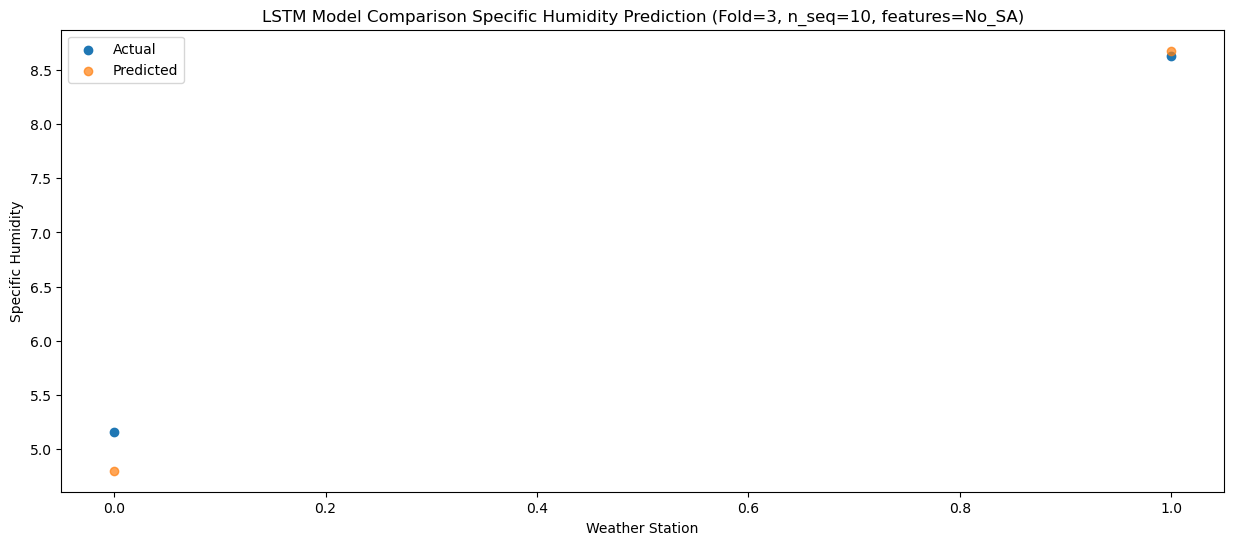

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0    4.77   4.425309
1                1    8.16   8.303983


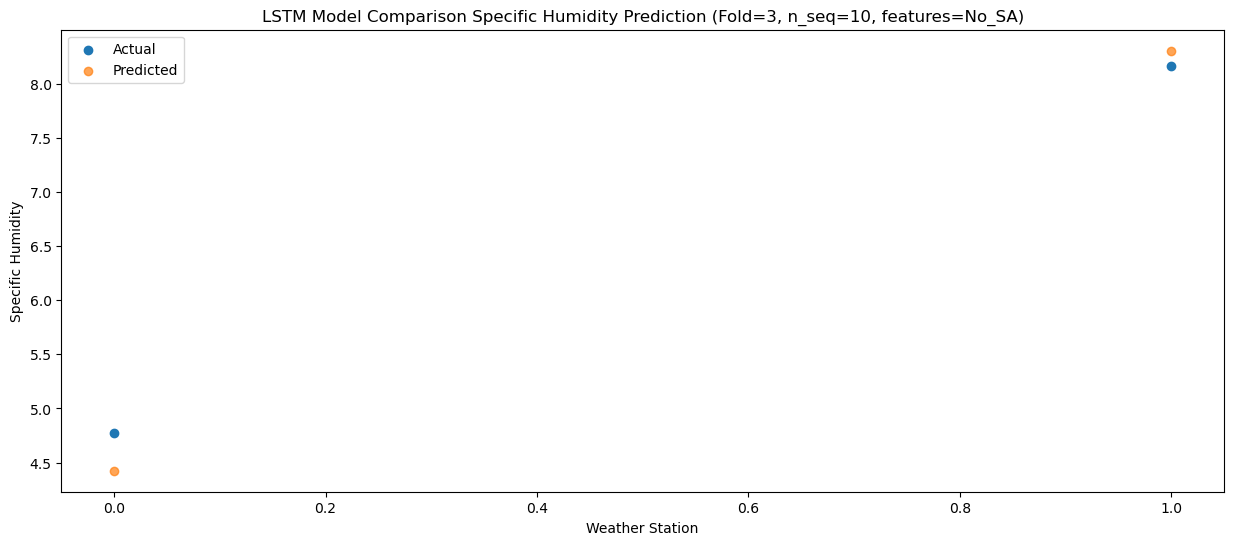

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0    5.34   4.525826
1                1    8.18   8.405539


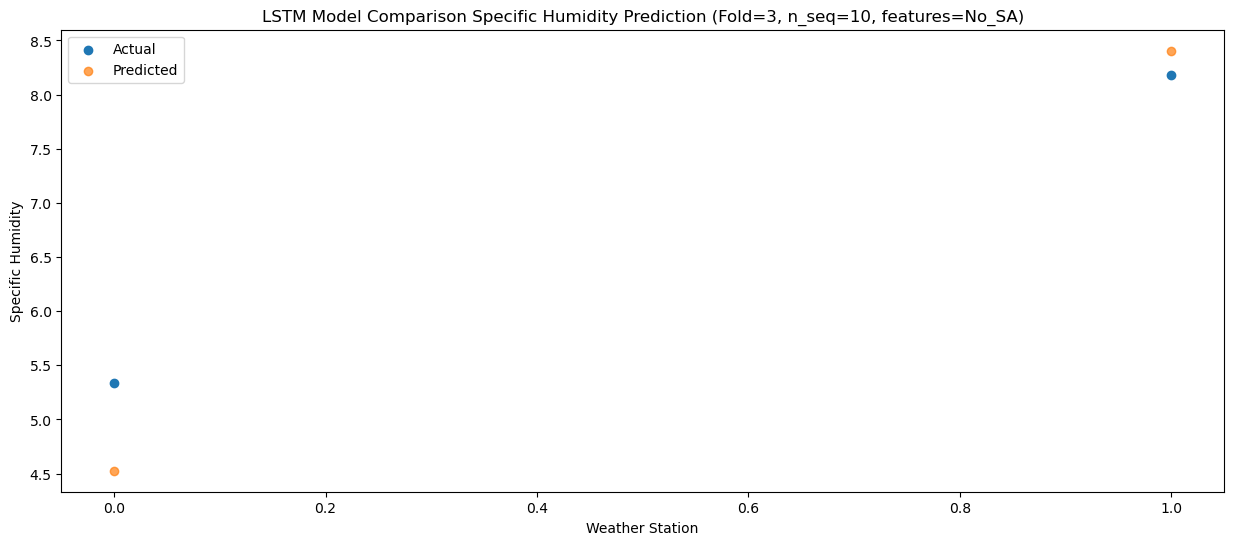

f, t:
[[4.92 7.95]
 [5.1  8.59]
 [4.94 8.69]
 [5.59 8.51]
 [5.17 8.87]
 [5.27 8.75]
 [5.62 8.66]
 [5.16 8.63]
 [4.77 8.16]
 [5.34 8.18]]
[[4.16954873 8.04968567]
 [4.8815941  8.75974955]
 [4.97118914 8.85031007]
 [4.98125282 8.85997937]
 [5.40963724 9.2888023 ]
 [4.85460606 8.73427394]
 [4.83124003 8.71062177]
 [4.79978119 8.67827164]
 [4.42530875 8.30398305]
 [4.52582579 8.40553939]]
Year at t+1:
t+1 SKRMSE: 0.535310
t+1 KRMSE: 0.535310
t+1 MAE: 0.425068
t+1 SKMAPE: 0.082535
t+1 R2_SCORE: 0.875151
t+1 KMAPE: 0.082535
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 6.435000
Year at t+2:
t+2 SKRMSE: 0.195597
t+2 KRMSE: 0.195597
t+2 MAE: 0.194078
t+2 SKMAPE: 0.031293
t+2 R2_SCORE: 0.987436
t+2 KMAPE: 0.031293
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 6.845000
Year at t+3:
t+3 SKRMSE: 0.115482
t+3 KRMSE: 0.115482
t+3 MAE: 0.095750
t+3 SKMAPE: 0.012381
t+3 R2_SCORE: 0.996207
t+3 KMAPE: 0.012381
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 6.815000
Year at t+4:
t+4 SKRMSE: 0.496517
t+4 KRMSE: 0.4965

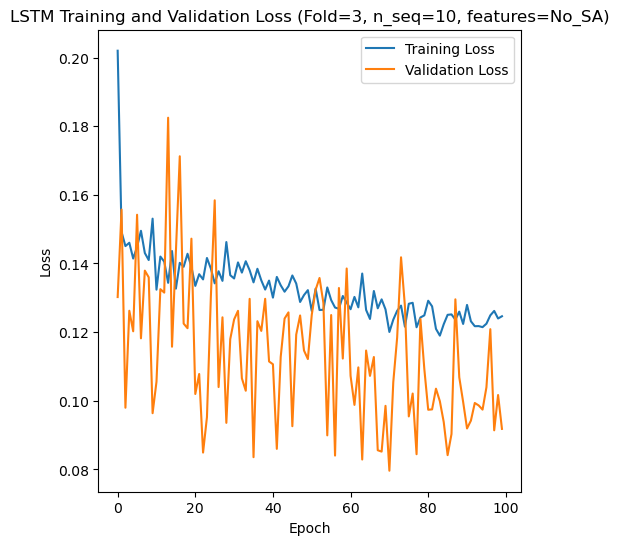

[[11.16  9.55  9.55 10.04  9.82  9.68 10.08  8.81  8.71 10.02  8.91  9.32
   9.71  8.86  9.35  8.98  8.99  9.85 10.25 10.41  9.69  9.69  9.59  9.94
   9.15  9.7  10.89]
 [ 8.33  7.32  7.52  7.52  7.95  7.22  7.21  7.13  7.15  7.14  7.22  7.24
   7.84  7.63  7.34  7.44  7.18  7.84  8.31  7.98  8.38  7.84  7.57  7.9
   7.3   7.53  8.43]]
Epoch 1/100
19/19 [==============================] - 5s 78ms/step - loss: 0.2080 - accuracy: 0.3158 - mae: 0.1676 - rmse: 0.2080 - mape: 37.4906 - pearson: 0.1705 - val_loss: 0.0973 - val_accuracy: 0.0000e+00 - val_mae: 0.0825 - val_rmse: 0.0973 - val_mape: 19.6856 - val_pearson: 0.2509
Epoch 2/100
19/19 [==============================] - 0s 13ms/step - loss: 0.1131 - accuracy: 0.3684 - mae: 0.0926 - rmse: 0.1131 - mape: 21.7399 - pearson: 0.2116 - val_loss: 0.0816 - val_accuracy: 0.3333 - val_mae: 0.0665 - val_rmse: 0.0816 - val_mape: 15.4150 - val_pearson: 0.1025
Epoch 3/100
19/19 [==============================] - 0s 11ms/step - loss: 0.1160 - accurac

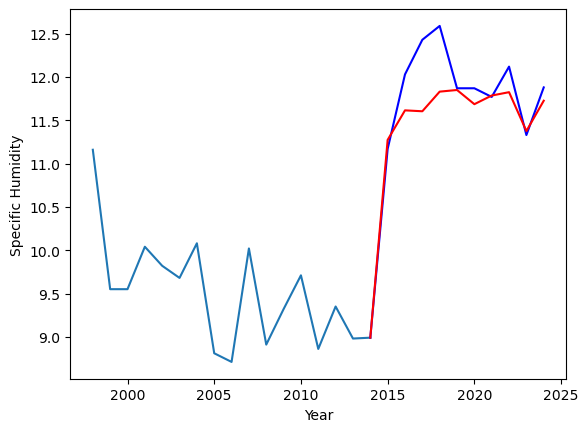

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.07		8.44		0.37
8.73		8.79		0.06
9.20		8.78		-0.42
8.87		9.00		0.13
9.27		9.02		-0.25
8.73		8.86		0.13
8.46		8.96		0.50
8.79		9.00		0.21
8.19		8.55		0.36
8.42		8.90		0.48


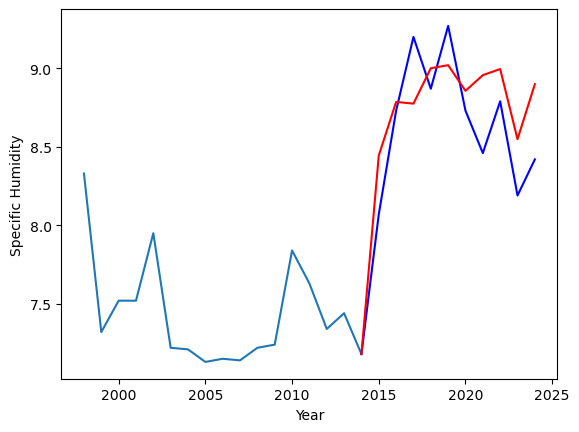

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   11.17  11.274017
1                1    8.07   8.444434


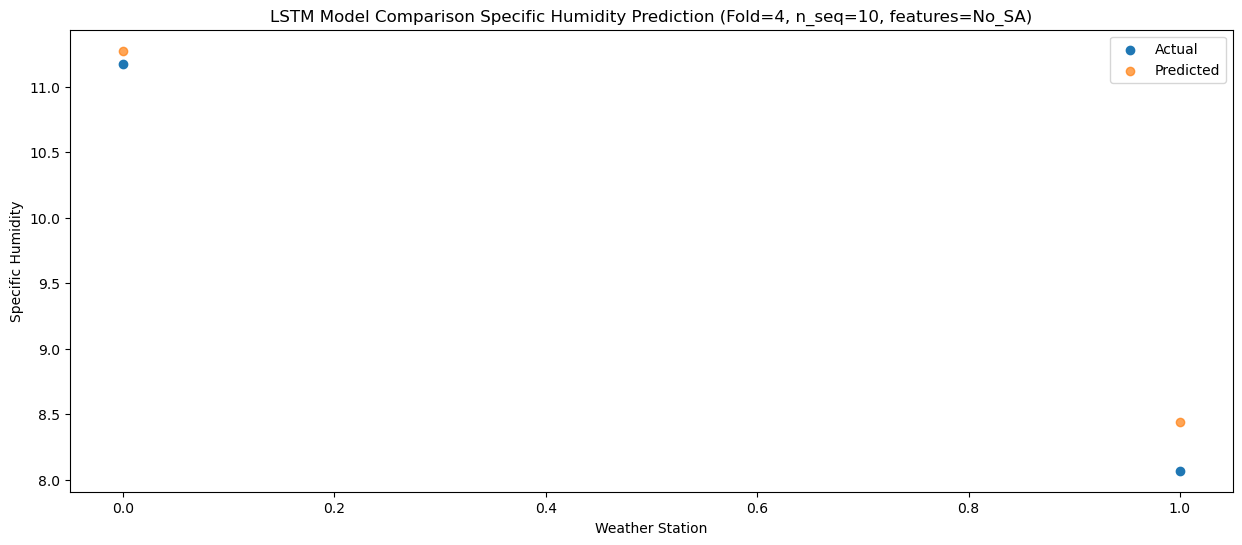

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   12.03  11.614938
1                1    8.73   8.785877


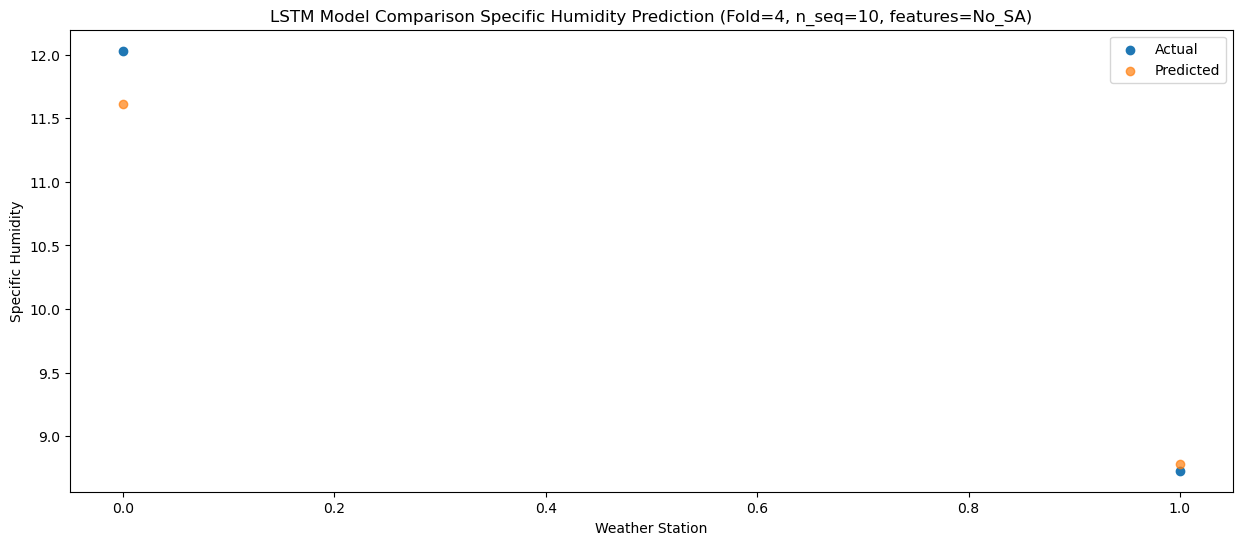

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   12.43  11.604435
1                1    9.20   8.775113


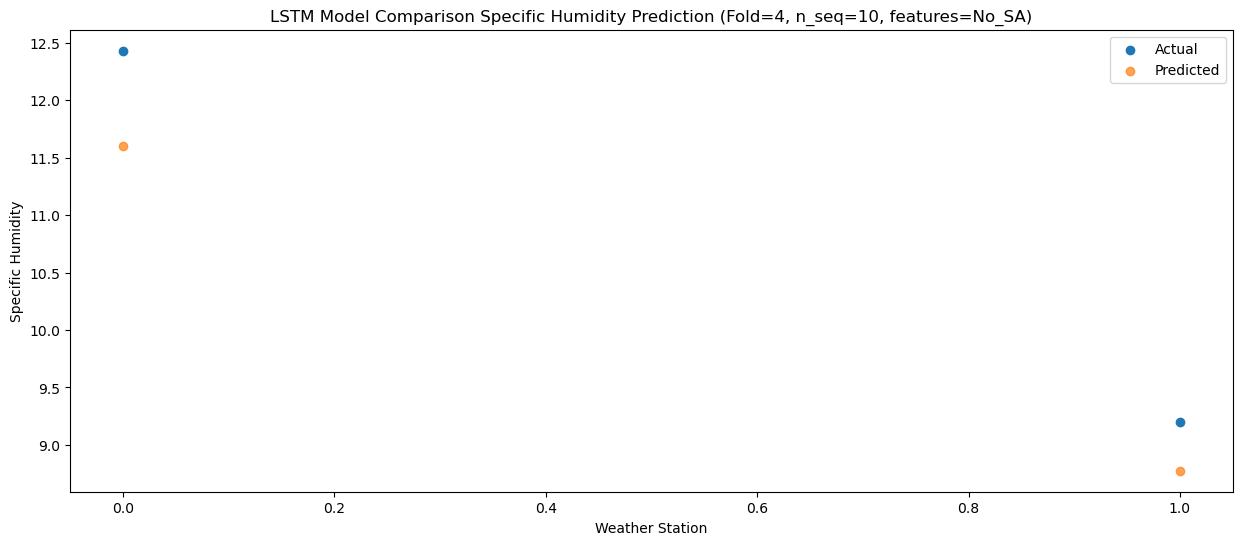

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   12.59  11.831139
1                1    8.87   9.000489


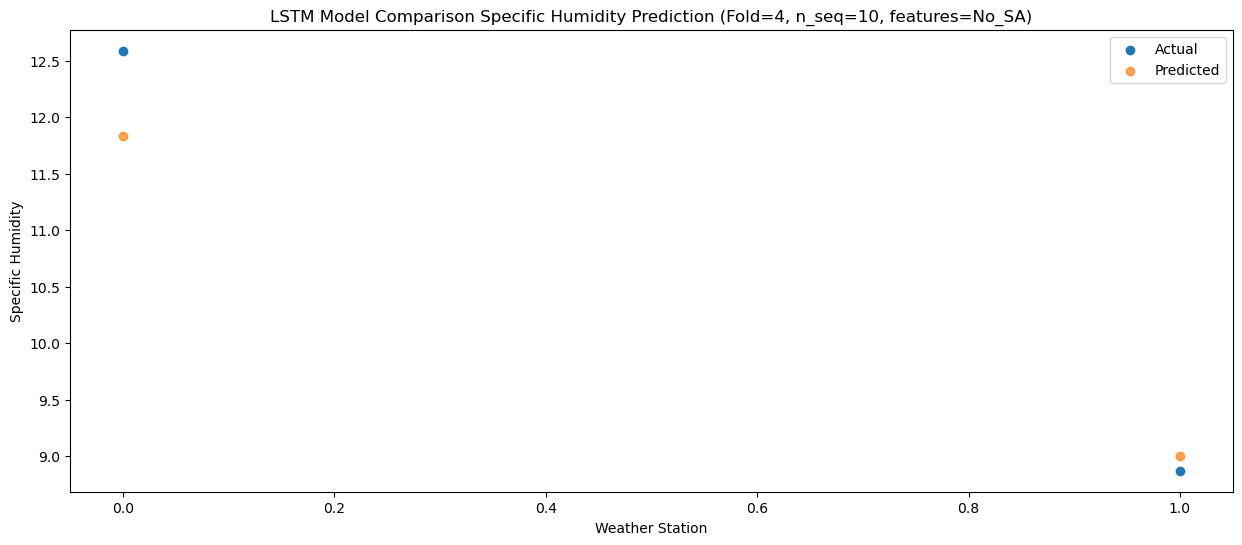

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   11.87  11.850203
1                1    9.27   9.020001


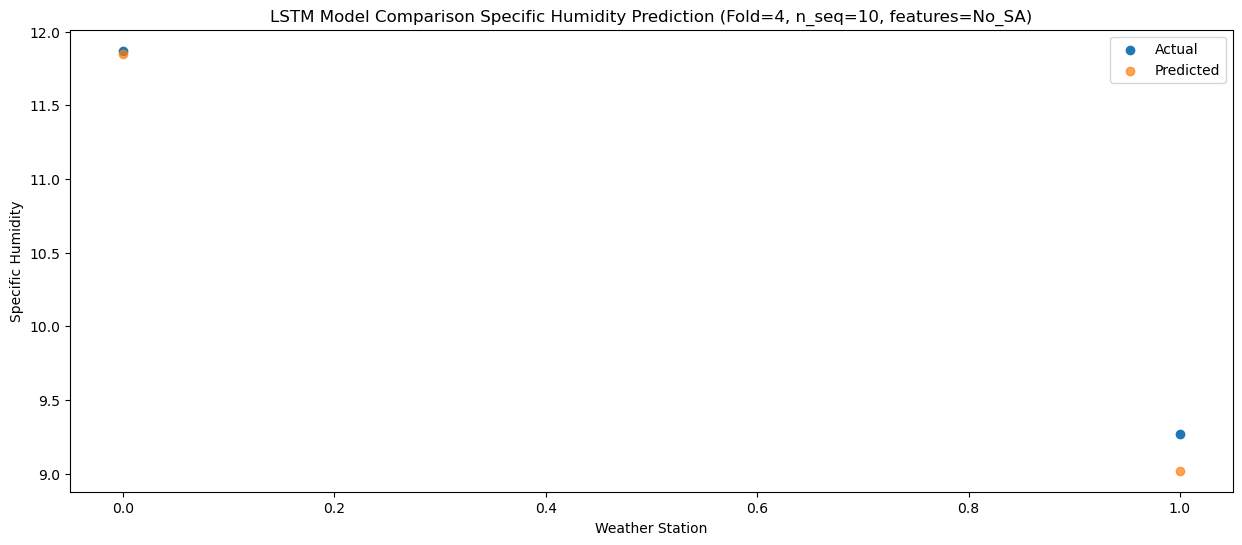

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   11.87  11.686244
1                1    8.73   8.856544


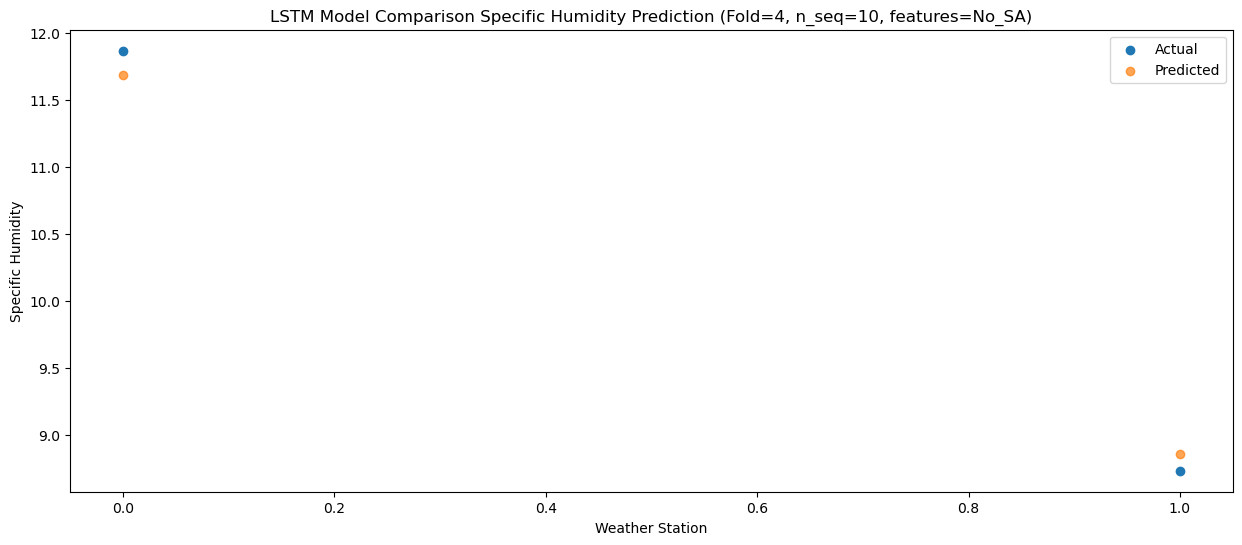

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   11.77  11.786149
1                1    8.46   8.956478


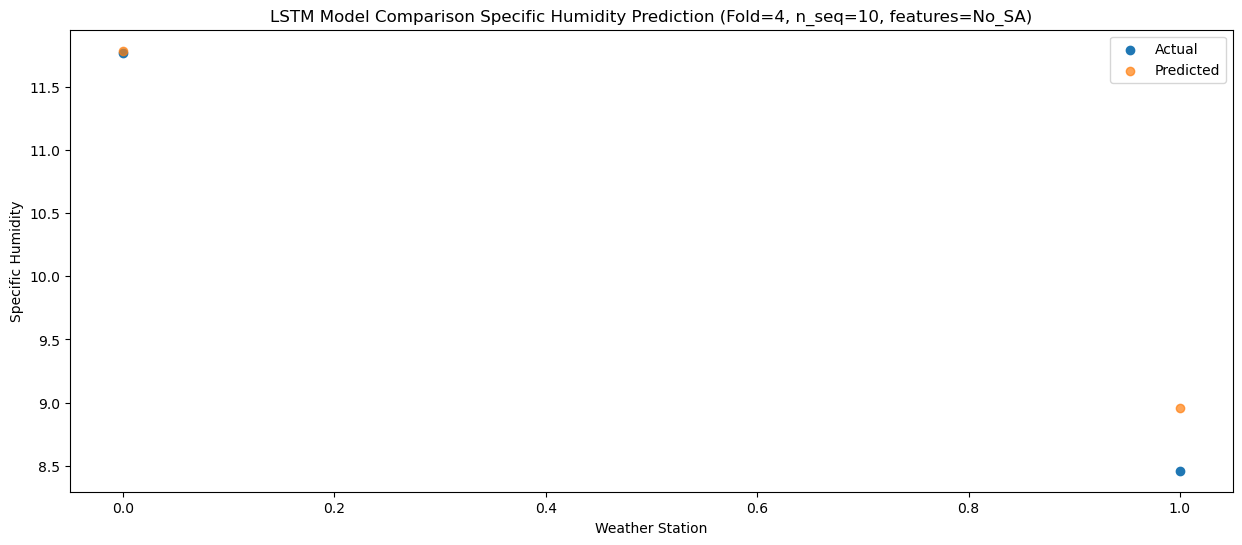

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   12.12  11.824912
1                1    8.79   8.995431


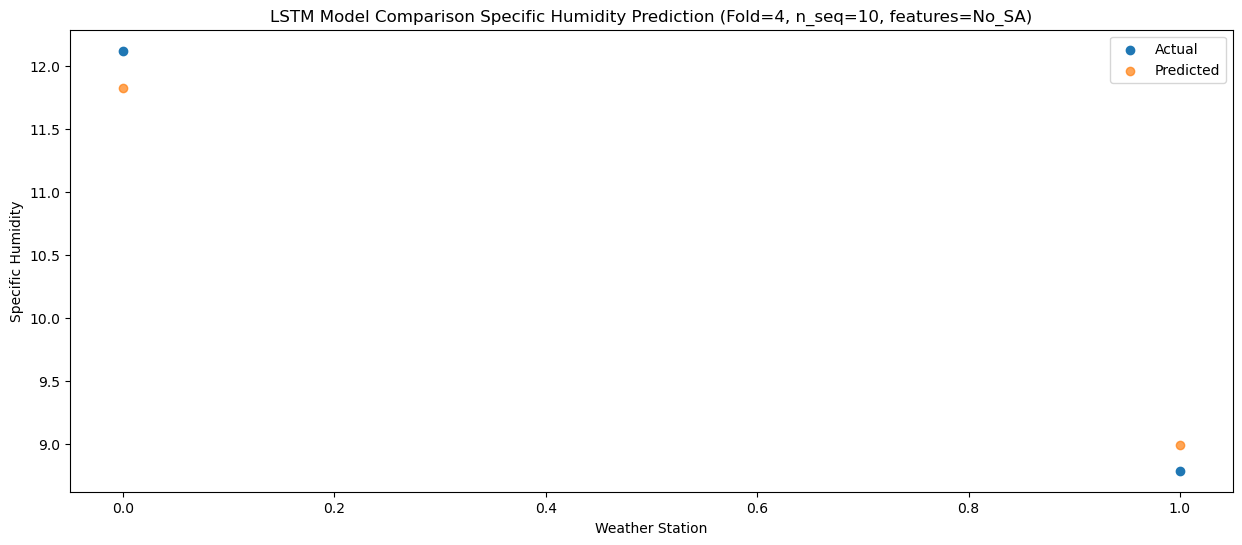

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   11.33  11.376087
1                1    8.19   8.548440


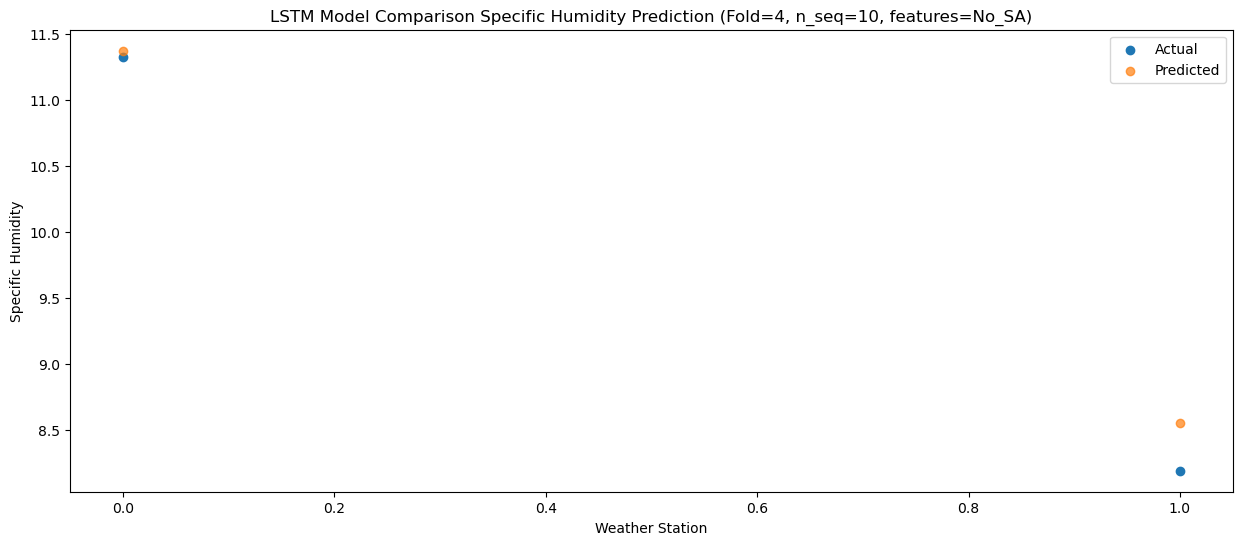

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   11.88  11.726213
1                1    8.42   8.899134


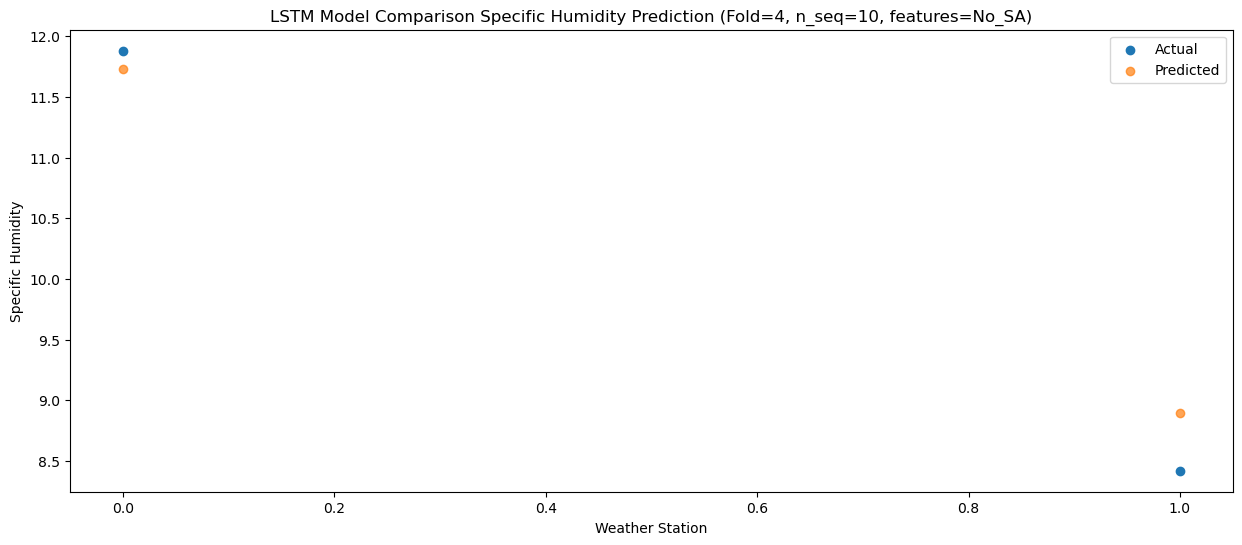

f, t:
[[11.17  8.07]
 [12.03  8.73]
 [12.43  9.2 ]
 [12.59  8.87]
 [11.87  9.27]
 [11.87  8.73]
 [11.77  8.46]
 [12.12  8.79]
 [11.33  8.19]
 [11.88  8.42]]
[[11.27401656  8.44443406]
 [11.6149382   8.78587742]
 [11.60443542  8.77511322]
 [11.83113918  9.00048926]
 [11.85020303  9.02000124]
 [11.68624392  8.8565443 ]
 [11.78614922  8.95647846]
 [11.82491176  8.9954306 ]
 [11.3760867   8.54843952]
 [11.72621258  8.8991339 ]]
Year at t+1:
t+1 SKRMSE: 0.274791
t+1 KRMSE: 0.274791
t+1 MAE: 0.239225
t+1 SKMAPE: 0.027855
t+1 R2_SCORE: 0.968570
t+1 KMAPE: 0.027855
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 9.620000
Year at t+2:
t+2 SKRMSE: 0.296141
t+2 KRMSE: 0.296141
t+2 MAE: 0.235470
t+2 SKMAPE: 0.020451
t+2 R2_SCORE: 0.967787
t+2 KMAPE: 0.020451
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 10.380000
Year at t+3:
t+3 SKRMSE: 0.656539
t+3 KRMSE: 0.656539
t+3 MAE: 0.625226
t+3 SKMAPE: 0.056300
t+3 R2_SCORE: 0.834737
t+3 KMAPE: 0.056300
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 10.815000
Year at t

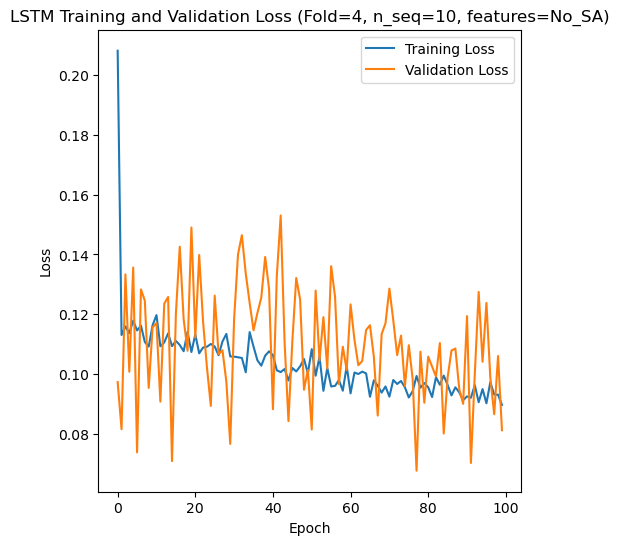

[[0.46258830685788566], [0.6718859256339981], [0.5255501036020395], [0.39906549554312526], [0.36427503312901144]]
[[array(0.46258831)], [array(0.67188593)], [array(0.5255501)], [array(0.3990655)], [array(0.36427503)]]
[[0.3547850330770018], [0.5043090472221375], [0.4197557105422024], [0.31271688861958696], [0.28599407224357154]]
[[0.029136728472858597], [0.05054340000843377], [0.043750092497817354], [0.053408636133959034], [0.028413523924469664]]
[[0.9103717210859391], [0.8762461979264001], [0.769065889818656], [0.9434422272497638], [0.9520603212278744]]
[[array(0.02913673)], [array(0.0505434)], [array(0.04375009)], [array(0.05340864)], [array(0.02841352)]]
[[array(0.93116753)], [array(0.92821403)], [array(0.84028779)], [array(0.98134362)], [array(0.96890152)]]
[12.78 13.83 13.92 14.3  13.46 13.41 13.53 13.34 13.05 13.36  9.71 10.79
 10.2  10.87 10.99 10.8  11.01 10.57 10.05 10.24 11.42 12.26 11.81 12.26
 12.81 12.14 12.5  11.83 11.88 11.74  7.95  9.08  9.06  8.69  8.53  8.56
  7.82  8

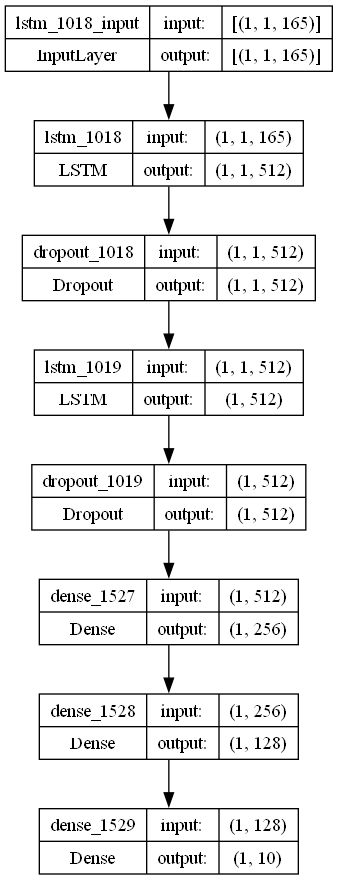

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit the best LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    lr = 0.03432745755855645
    optimizer = SGD(learning_rate = lr)
    activation_function = 'sigmoid'
    lstm_units = 512
    dropout_rate = 0.31042336103376866

    # design network
    model = Sequential()
    #model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# make one forecast with an LSTM,
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []
    actual_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        avg_actual = np.mean(act)
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))
        print('t+%d AVERAGE ACTUAL: %f' % ((i+1), avg_actual))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    avg_actual = np.mean(np.array(y_true))
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    actual_list.append(avg_actual)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))
    print('AVERAGE ACTUAL: %f' % (avg_actual))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list
     
# Plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # Plot the actual data in blue
    plt.plot(series[:n_lag+2].index, series[:n_lag+2].values)
    off_s = n_lag + 1
    off_e = off_s + len(actual) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + actual
    plt.plot(xaxis, yaxis, color='blue')
    # Plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Year")
    plt.ylabel("Specific Humidity")
    # show the plot
    plt.show()

n_batch = 1
n_test = 2
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
actual_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:2, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (specific_humidity)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = [1,2]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(2):
        print("Weather Station "+str(j+1)+":")
        print("Actual S.H.\tPredicted S.H.\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:2, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (specific_humidity)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]

        # Set index starting from 1998
        series_ws.index = range(1998, 1998 + len(series_ws))        
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(2):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='LSTM Model Comparison Specific Humidity Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_SA)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Specific Humidity')
        plt.legend()
        plt.show()
    
    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction
    actual_list = [] # list stores average actual values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)
    actual_avg_list.append(actual_list)
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_SA)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(np.array(actual_results).flatten())
print(np.array(forecast_results).flatten())
a2 = np.array(actual_results).flatten()
f2 = np.array(forecast_results).flatten()
p1 = np.array(pearson(tf.convert_to_tensor(a2), tf.convert_to_tensor(f2)))
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(p1))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))
print("")
print("Average Specific Humidity:"+str(np.mean(actual_avg_list)))
print("RMSE % of Specific Humidity:"+str(np.mean(rmse2_avg_list)/np.mean(actual_avg_list)))

# Plot model architecture
filename = "lstm_model_optimized_SH_S10_No_SA.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)